In [57]:
import os
import glob

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from collections import Counter

from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

import datetime

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [59]:
from sklearn.naive_bayes import MultinomialNB

from sklearn import metrics

## define helper functions

In [60]:
# initialize 7 margins
margins = {'amount': 600,
          'authorization': 600,
          'date' : 600,
          'count' : 600,
          'intention' : 600,
          'utilization':600,
          'unknown':600}

In [61]:
def get_relevant_key_word_tokens(df_col, most_common = 10, inverse = False, least_common = 10):
    '''Takes a data frame and column name and returns a list of key word tokens. If inverse, then it will return the 10 least common tokens'''
    # make sure the column is strings
    for cell in df_col:
        assert(type(cell) == str)
    text_list = [t.lower() for t in df_col]
    text_string = ''
    for t in text_list:
        text_string = text_string + t + ' '
    text_tokens = [w for w in word_tokenize(text_string) if (w.isalnum() and w not in stopwords.words('english'))]
    if inverse:
        key_tokens = pd.DataFrame(Counter(text_tokens).most_common()).tail(10)
    else:
        key_tokens = pd.DataFrame(Counter(text_tokens).most_common(most_common))

    key_tokens.columns = ['key_tok', 'kt_count']
    
    return key_tokens


def define_nominated_paragraphs(filing, key_tokens, margin):
    '''takes an html filing, key_tokens, paragraph margin and returns nominated paragraphs'''
    
    # read in an html
    with open(filing) as file:
        file_html = file.read()
        
    # parse html
    parsed_html = BeautifulSoup(file_html, 'lxml')
    # filter out the html head, css, and cast to lower case
    string_filing = parsed_html.body.text.lower()
    
    ##################------- Predict Paragraphs ------##############################################
    #define candidate paragraphs by addin margins to each hit
    #
    #------ generate a list of token mathces / "hits"------------------------------
    #
    # collect the start and end indices of each token "hit." into an ugly list of lists of tuples
    lst_of_token_hits_lst = []
    for i in range(len(key_tokens.key_tok[0:10])):
        kt = key_tokens.key_tok[i]
        lst_of_token_hits_lst.append([(str(kt), m.start(), m.end()) for m in re.finditer(kt, string_filing)])
    #
    # flatten the ugly list of lists of tuples into a list of tuples
    flater_list_of_tokhits = [tpl for sublist in lst_of_token_hits_lst for tpl in sublist]
    #
    # order the list of token_hit tuples by starting index
    flater_list_of_tokhits.sort(key = lambda x: x[1])
    #
    #-------- use the token hits to define the bounds of the candidate paragraphs -------
    #
    # initialize a list of candidate paragraph bounds
    candidate_paragraphs = []
    
    for i in range(len(flater_list_of_tokhits)):
    #    
    #    # initialize the left and right bound of a paragraph
        leftbound = flater_list_of_tokhits[i][1] - margin
        rightbound = flater_list_of_tokhits[i][2] + margin
        
        # ensure bounds are not out of index range
        if leftbound < 0:
            leftbound = 0
        if rightbound > len(string_filing):
            rightbound = len(string_filing)

        par_bounds = (leftbound, rightbound) 
        candidate_paragraphs.append(par_bounds)
    
    return candidate_paragraphs, string_filing

In [62]:
def define_nominated_texts(par, key_tokens, margin):
    '''takes a paragraph, key_tokens, text margin and returns nominated texts'''
    
    ##################------- Predict texts ------##############################################
    #define candidate texts by adding margins to each hit
    #
    #------ generate a list of token mathces / "hits"------------------------------
    #
    # collect the start and end indices of each token "hit." into an ugly list of lists of tuples
    lst_of_token_hits_lst = []
    for i in range(len(key_tokens.key_tok[:])):
        kt = key_tokens.key_tok[i]
        if kt not in par:
            continue
        lst_of_token_hits_lst.append([(str(kt), m.start(), m.end()) for m in re.finditer(kt, par)])
    #
    # flatten the ugly list of lists of tuples into a list of tuples
    flater_list_of_tokhits = [tpl for sublist in lst_of_token_hits_lst for tpl in sublist]
    #
    # order the list of token_hit tuples by starting index
    flater_list_of_tokhits.sort(key = lambda x: x[1])
    #
    #-------- use the token hits to define the bounds of the candidate paragraphs -------
    #
    # initialize a list of candidate texts bounds
    candidate_texts = []
    
    for i in range(len(flater_list_of_tokhits)):
    #    
    #    # initialize the left and right bound of a paragraph
        leftbound = flater_list_of_tokhits[i][1] - margin
        rightbound = flater_list_of_tokhits[i][2] + margin
        
        # ensure bounds are not out of index range
        if leftbound < 0:
            leftbound = 0
        if rightbound > len(par):
            rightbound = len(par)

        par_bounds = (leftbound, rightbound) 
        candidate_texts.append(par_bounds)
    
    return candidate_texts, par

In [63]:
def measure_inclusion(predicted_par, test_par, verbose = False):
    '''takes two strings, eliminates excess spaces and new lines and stopwords, casts to lower, tokenizes and then compares inclusion'''
    # pre process paragraphs and generate tokens
    pred = re.sub(r'\n+', ' ', predicted_par)
    pred = re.sub(r'\s+', ' ', pred)
    pred = pred.lower()
    pred_tokens = [wt for wt in word_tokenize(pred) if (wt.isalnum() and wt not in stopwords.words('english'))]
    if len(pred) == 0:
        pred_tokens = [np.nan]
    
    test = re.sub(r'\n+', ' ', test_par)
    test = re.sub(r'\s+', ' ', test)
    test = test.lower()
    test_tokens = [wt for wt in word_tokenize(test) if (wt.isalnum() and wt not in stopwords.words('english'))]
    
    # calculate total inclusion
    total_inclusion = False
    if test in pred:
        total_inclusion = True
    # calculate test-inclusion percentage ()
    counter = 0
    for wt in test_tokens:
        if wt in pred_tokens:
            counter += 1
    if len(test_tokens) == 0:
        inclusion_pct = np.nan
    else:
        inclusion_pct = round(100*counter/len(test_tokens), 2)
    
    # calculate extra baggage percentage
    bag_counter = 0
    for wt in pred_tokens:
        if wt not in test_tokens:
            bag_counter += 1
    if len(pred_tokens) == 0:
        baggage_pct = np.nan
    else:
        baggage_pct = round(100*bag_counter/len(pred_tokens), 2)
    
    # package results for output
    results = {'total_inclusion' : total_inclusion,
              'inclusion_pct' : inclusion_pct,
              'baggage_pct': baggage_pct,
              'pred_tokenized_par_len': len(pred_tokens),
              'test_tokenized_par_len': len(test_tokens)}
    
    # reporting
    if verbose == True:
        print(results)
    
    return results
    

In [64]:
def report_inclusion(df):
    '''outputs printed and visualized report of inclusion rates'''
    # total inclusion rate
    print("For each test text, how many of them are 100% included in the predicted text?")
    print(round(100*(df.predtext_totinc.sum())/len(df.predtext_totinc), 2), '% total inclusion')
    print("-"*30)
    
    # report inclusion_rate
    print('For each test text, how much of it is included in the corresponding predicted text?')
    df.predtext_inclpct.plot(kind = 'hist', color = 'limegreen', alpha = 1)
    plt.title('Histogram of Inclusion Rates')
    plt.grid()
    plt.show()
    print('-- Mean inclusion rate', np.mean(df.predtext_inclpct))
    print('-- Median inclusion rate', df.predtext_inclpct.median())
    print("--------------------------")
    print("")

In [65]:
def get_model_paragraph(nom_pars, string_filing, model = 'token_density', key_tokens = None, vectorizer = None, verbose = False, inverse = False):
    '''takes a list of tuples of nominated paragraph bounds and a their corresponding document and returns one paragraph'''
    nominee = ''
    best_proba = 0.0
    for tpl in nom_pars:
        # generate par
        par = string_filing[tpl[0]:tpl[1]]
        # pre process par
        par = re.sub(r'\n+', ' ', par)
        par = re.sub(r'\s+', ' ', par)
        
        # if the naiver bayes prediction of classification as a given dkfn's class is new_best probability
        
        if model == 'token_density' and key_tokens.key_tok[0] in par and key_tokens.key_tok[1] in par and key_tokens.key_tok[2] in par:
            #assert key_tokens != None
            hits = 0
            w_tokens = [wt for wt in word_tokenize(par) if (wt.isalnum() and wt not in stopwords.words('english'))]
            if len(w_tokens) == 0:
                print(par)
            for wt in w_tokens:
                if wt in key_tokens.key_tok.values:
                    hits += 1
            #tk_density = hits/len(w_tokens)
            #if tk_density > best_proba:
            if hits > best_proba:
                best_proba = hits
                nominee = par
                #best_proba = tk_density
            
        elif model != 'token_density':
            #assert vectorizer != None
            # tfidf_vectorize the string into a sparse matrix
            par_vectorized = vectorizer.transform([par])
        
            # if using inverse we'll select the model's least favorite predictions
            # ------------------------------ prediction of being in the class == False -------------------------------- probability of it being false
            if inverse and model.predict(par_vectorized)[0] == 0 and model.predict_proba(par_vectorized)[0][0] > best_proba:
                nominee = par
                best_proba = model.predict_proba(par_vectorized)[0][0]
            
            # if not using inverse
            elif model.predict(par_vectorized)[0] == 1 and model.predict_proba(par_vectorized)[0][1] > best_proba:
                #print(nb_auth_classifier.predict_proba(par_vectorized))
                nominee = par
                #print(nominee)
                best_proba = model.predict_proba(par_vectorized)[0][1]
            
        # write the results
        results_dct = {'nominee' : nominee,
                      'best_proba' : best_proba}
    
    if verbose:
        print('best probability', best_proba)
        print('-'*100)
        print(nominee)
        print('='*100)
    
    return results_dct

## read, my paragraph predictions csv

In [66]:
share_rprchs_prgrph_df = pd.read_csv('ml_predictions_validated.csv', index_col=0)

In [67]:
share_rprchs_prgrph_df.drop('Unnamed: 0.1', axis = 'columns', inplace=True)
share_rprchs_prgrph_df.head()

,ticker,accession_number,data_key_friendly_name,text,data_value,reported_data_value,reported_units,paragraph_text,pred_par,amount,...,count,intention,utilization,unknown,pred_proba,tknzd_tst_par_len,tot_incl,inclusion_pct,baggage_pct,tknzd_pred_par_len
0,A,0001090872-17-000018,Share Repurchase Authorization Date,"May 28, 2015",20150528,20200000.00,ones,"On May 28, 2015 we announced that our board ...","ases under this authorization. on may 28, 2015...",0,...,0,0,0,0,0.975636,46.0,False,97.83,40.00,['pred_tokenized_par_len']
1,A,0001090872-17-000018,Share Repurchase Authorization,The 2015 share repurchase program authorizes t...,1140000000,1.14,billions,"On May 28, 2015 we announced that our board ...","31, 2016 we repurchased approximately 2.4 mil...",0,...,0,0,0,0,0.988679,46.0,False,97.83,40.91,['pred_tokenized_par_len']
2,A,0001090872-17-000018,Share Repurchase Intention,remaining authorization to repurchase up to,610000000,610.00,millions,"Table of Contents 2016, upon the completion ...","zation. on may 28, 2015 we announced that our ...",0,...,0,1,0,0,0.999220,38.0,False,94.74,47.27,['pred_tokenized_par_len']
3,A,0001090872-17-000018,Share Repurchase Count,repurchased,4100000,4.10,millions,"Table of Contents 2016, upon the completion ...",ed the purchases under this authorization. on ...,0,...,1,0,0,0,0.994602,38.0,False,94.74,46.36,['pred_tokenized_par_len']
4,A,0001090872-17-000018,Amount Spent on Share Repurchases,repurchased,194000000,194.00,millions,"Table of Contents 2016, upon the completion ...",ed the purchases under this authorization. on ...,1,...,0,0,0,0,0.991570,38.0,False,94.74,46.36,['pred_tokenized_par_len']


In [68]:
share_rprchs_prgrph_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1772 entries, 0 to 1771
Data columns (total 22 columns):
ticker                    1772 non-null object
accession_number          1772 non-null object
data_key_friendly_name    1772 non-null object
text                      1772 non-null object
data_value                1772 non-null int64
reported_data_value       1772 non-null float64
reported_units            1772 non-null object
paragraph_text            1772 non-null object
pred_par                  1772 non-null object
amount                    1772 non-null int64
authorization             1772 non-null int64
date                      1772 non-null int64
count                     1772 non-null int64
intention                 1772 non-null int64
utilization               1772 non-null int64
unknown                   1772 non-null int64
pred_proba                1772 non-null float64
tknzd_tst_par_len         1772 non-null float64
tot_incl                  1772 non-null bool
inclusi

#### fix the'tknzd_pred_par_len' column

In [69]:
for i in range(len(share_rprchs_prgrph_df.pred_par)):
    pred = re.sub(r'\n+', ' ', share_rprchs_prgrph_df.pred_par[i])
    pred = re.sub(r'\s+', ' ', pred)
    pred = pred.lower()
    # get length of it 
    share_rprchs_prgrph_df.tknzd_pred_par_len[i] = len([wt for wt in word_tokenize(pred) if (wt.isalnum() and wt not in stopwords.words('english'))])
    #print('processed row', i, 'of', 1772, i/1772, '% done')

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [70]:
share_rprchs_prgrph_df.tknzd_pred_par_len[0:5]

0    110
1    110
2    110
3    110
4    110
Name: tknzd_pred_par_len, dtype: object

============================== Inclusion Report ==================================================
For each test paragraph, how many of them are 100% included in the predicted paragraph?
19.47 % total inclusion
------------------------------
For each test paragraph, how much of it is included in the corresponding predicted paragraph?


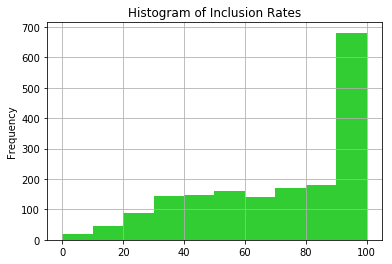

-- Mean inclusion rate 71.95947516930025
-- Median inclusion rate 78.18
--------------------------

For each predicted paragraph, how much of it is extra content not in the test paragraph?


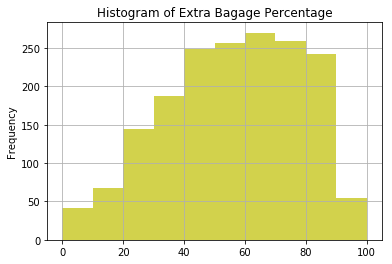

-- mean bagage rate:  56.12998306997744
-- median bagage rate:  57.82
----------------

What is the distribution of lengths of the word tokenized test paragraphs.


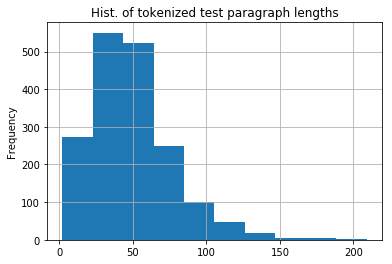

-- Mean tokenized test paragraph length  49.715011286681715
-- Median tokenized test paragraph length 46.0
-- Range of tokenized test paragraph lengths 207.0
------------------------------

What is the distribution of lengths of the word tokenized test paragraphs.


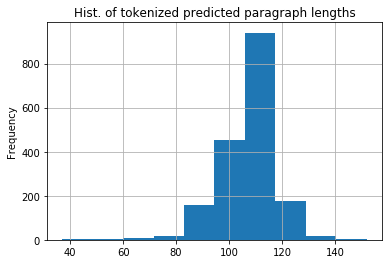

-- mean tokenized predicted parag. lenghts 107.33521444695259
-- median tokenized predicted parag. lenghts 108.0
-- range of tokenized predicted parag. lenghts 115
------------------------------



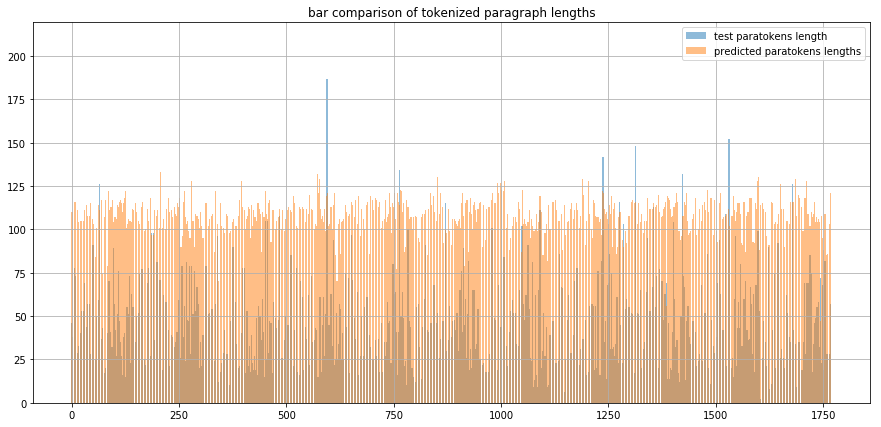

In [71]:
# report and plot the overall inclusion
print('='*30, 'Inclusion Report', '='*50)

# total inclusion rate
print("For each test paragraph, how many of them are 100% included in the predicted paragraph?")
print(round(100*(share_rprchs_prgrph_df.tot_incl.sum())/len(share_rprchs_prgrph_df.tot_incl), 2), '% total inclusion')
print("-"*30)

# report inclusion_rate
#plt.hist(share_rprchs_prgrph_df.inclusion_pct, bins=20)
print('For each test paragraph, how much of it is included in the corresponding predicted paragraph?')
share_rprchs_prgrph_df.inclusion_pct.plot(kind = 'hist', color = 'limegreen', alpha = 1)
plt.title('Histogram of Inclusion Rates')
plt.grid()
plt.show()
print('-- Mean inclusion rate', np.mean(share_rprchs_prgrph_df.inclusion_pct))
print('-- Median inclusion rate', share_rprchs_prgrph_df.inclusion_pct.median())
print("--------------------------")
print("")

# report extra baggage rate
#plt.hist(share_rprchs_prgrph_df.baggage_pct)
print('For each predicted paragraph, how much of it is extra content not in the test paragraph?')
share_rprchs_prgrph_df.baggage_pct.plot(kind = 'hist', color = 'y', alpha = .7)
plt.title('Histogram of Extra Bagage Percentage')
plt.grid()
plt.show()
print('-- mean bagage rate: ', np.mean(share_rprchs_prgrph_df.baggage_pct))
print('-- median bagage rate: ', share_rprchs_prgrph_df.baggage_pct.median())
print("----------------")
print("")

# report lengths of tokenized paragraphs
print("What is the distribution of lengths of the word tokenized test paragraphs.")
share_rprchs_prgrph_df.tknzd_tst_par_len.plot(kind = 'hist')
plt.title('Hist. of tokenized test paragraph lengths')
plt.grid()
plt.show()
print('-- Mean tokenized test paragraph length ', np.mean(share_rprchs_prgrph_df.tknzd_tst_par_len))
print('-- Median tokenized test paragraph length', share_rprchs_prgrph_df.tknzd_tst_par_len.median())
print('-- Range of tokenized test paragraph lengths', np.max(share_rprchs_prgrph_df.tknzd_tst_par_len) - np.min(share_rprchs_prgrph_df.tknzd_tst_par_len))
print("-"*30)
print("")

#plt.hist(share_rprchs_prgrph_df.tknzd_pred_par_len)
print("What is the distribution of lengths of the word tokenized test paragraphs.")
share_rprchs_prgrph_df.tknzd_pred_par_len.plot(kind = 'hist')
plt.title('Hist. of tokenized predicted paragraph lengths')
plt.grid()
plt.show()
print('-- mean tokenized predicted parag. lenghts', np.mean(share_rprchs_prgrph_df.tknzd_pred_par_len))
print('-- median tokenized predicted parag. lenghts', share_rprchs_prgrph_df.tknzd_pred_par_len.median())
print('-- range of tokenized predicted parag. lenghts', (np.max(share_rprchs_prgrph_df.tknzd_pred_par_len)) - np.min(share_rprchs_prgrph_df.tknzd_pred_par_len))
print("-"*30)
print("")
# plot overlay of each paragraph's lengths
plt.figure(figsize = (15,7))
plt.bar(height = share_rprchs_prgrph_df.tknzd_tst_par_len.fillna(np.nan), alpha = 0.5,
        x = range(len(share_rprchs_prgrph_df.paragraph_text)))
        #x = range(len(share_rprchs_prgrph_df.tknzd_tst_par_len.fillna(value = np.nan))))
plt.bar(height = share_rprchs_prgrph_df.tknzd_pred_par_len.fillna(np.nan), alpha = 0.5,
        x = range(len(share_rprchs_prgrph_df.paragraph_text)))
       #x = range(len(share_rprchs_prgrph_df.tknzd_pred_par_len.fillna(value = np.nan))))
plt.title('bar comparison of tokenized paragraph lengths')
plt.legend(['test paratokens length', 'predicted paratokens lengths'])
plt.grid()
plt.show()

### fit and train a df['text'] classification model for each dkfn

In [72]:
# split data into train, fit and test subsets
X_train, X_test, y_train_ix, y_test_ix = train_test_split(share_rprchs_prgrph_df.text,
                                                   share_rprchs_prgrph_df.index, ### Watchout this is just a placeholder for now
                                                   test_size = 0.33,
                                                   random_state = 53)
# initialize a TfidfVectorizer object
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df = 0.7)

In [73]:
# transform the training data
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

# transform the test data
tfidf_test = tfidf_vectorizer.transform(X_test)

In [74]:
# make and fit a model for each dkfn
nb_amnt_classifier = MultinomialNB()
nb_amnt_classifier.fit(tfidf_train, 
                       share_rprchs_prgrph_df.amount[[ix in y_train_ix for ix in share_rprchs_prgrph_df.index]])
nb_auth_classifier = MultinomialNB()
nb_auth_classifier.fit(tfidf_train, 
                       share_rprchs_prgrph_df.authorization[[ix in y_train_ix for ix in share_rprchs_prgrph_df.index]])
nb_dt_classifier = MultinomialNB()
nb_dt_classifier.fit(tfidf_train, 
                       share_rprchs_prgrph_df.date[[ix in y_train_ix for ix in share_rprchs_prgrph_df.index]])
nb_cnt_classifier = MultinomialNB()
nb_cnt_classifier.fit(tfidf_train, 
                       share_rprchs_prgrph_df['count'][[ix in y_train_ix for ix in share_rprchs_prgrph_df.index]])
nb_intent_classifier = MultinomialNB()
nb_intent_classifier.fit(tfidf_train, 
                       share_rprchs_prgrph_df.intention[[ix in y_train_ix for ix in share_rprchs_prgrph_df.index]])
nb_util_classifier = MultinomialNB()
nb_util_classifier.fit(tfidf_train, 
                       share_rprchs_prgrph_df.utilization[[ix in y_train_ix for ix in share_rprchs_prgrph_df.index]])
nb_unk_classifier = MultinomialNB()
nb_unk_classifier.fit(tfidf_train, 
                       share_rprchs_prgrph_df.unknown[[ix in y_train_ix for ix in share_rprchs_prgrph_df.index]])


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

**Horizontally Validate the seven models**

In [75]:
models_lst = [nb_amnt_classifier, nb_auth_classifier, nb_cnt_classifier, nb_dt_classifier,
             nb_intent_classifier, nb_unk_classifier, nb_util_classifier]

for mod, col in zip(models_lst, ['amount', 'authorization', 'count' ,'date', 'intention', 'unknown', 'utilization']):
    pred = mod.predict(tfidf_test)
    score = metrics.accuracy_score(share_rprchs_prgrph_df[col][[ix in y_test_ix for ix in share_rprchs_prgrph_df.index]], pred)
    print(round(100*score, 1), '%', col, 'accuracy')

80.3 % amount accuracy
79.0 % authorization accuracy
84.6 % count accuracy
76.9 % date accuracy
86.3 % intention accuracy
93.2 % unknown accuracy
97.8 % utilization accuracy


In [76]:
## stage a countvectorizer
count_vectorizer = CountVectorizer(stop_words='english')
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)

#make and fit model for each dkfn
second_amnt_nb_classifier = MultinomialNB()
second_amnt_nb_classifier.fit(count_train, 
                       share_rprchs_prgrph_df.amount[[ix in y_train_ix for ix in share_rprchs_prgrph_df.index]])
second_auth_nb_classifier = MultinomialNB()
second_auth_nb_classifier.fit(count_train, 
                       share_rprchs_prgrph_df.amount[[ix in y_train_ix for ix in share_rprchs_prgrph_df.index]])
second_dt_nb_classifier = MultinomialNB()
second_dt_nb_classifier.fit(count_train, 
                       share_rprchs_prgrph_df.amount[[ix in y_train_ix for ix in share_rprchs_prgrph_df.index]])
second_cnt_nb_classifier = MultinomialNB()
second_cnt_nb_classifier.fit(count_train, 
                       share_rprchs_prgrph_df.amount[[ix in y_train_ix for ix in share_rprchs_prgrph_df.index]])
second_intent_nb_classifier = MultinomialNB()
second_intent_nb_classifier.fit(count_train, 
                       share_rprchs_prgrph_df.amount[[ix in y_train_ix for ix in share_rprchs_prgrph_df.index]])
second_util_nb_classifier = MultinomialNB()
second_util_nb_classifier.fit(count_train, 
                       share_rprchs_prgrph_df.amount[[ix in y_train_ix for ix in share_rprchs_prgrph_df.index]])
second_unk_nb_classifier = MultinomialNB()
second_unk_nb_classifier.fit(count_train, 
                       share_rprchs_prgrph_df.amount[[ix in y_train_ix for ix in share_rprchs_prgrph_df.index]])

# Horizontally Validate the second seven models
second_models_lst = [second_amnt_nb_classifier, second_auth_nb_classifier, second_cnt_nb_classifier, second_dt_nb_classifier,
             second_intent_nb_classifier, second_unk_nb_classifier, second_util_nb_classifier]

for mod, col in zip(second_models_lst, ['amount', 'authorization', 'count' ,'date', 'intention', 'unknown', 'utilization']):
    pred = mod.predict(count_test)
    score = metrics.accuracy_score(share_rprchs_prgrph_df[col][[ix in y_test_ix for ix in share_rprchs_prgrph_df.index]], pred)
    print(round(100*score, 1), '%', col, 'accuracy')

79.5 % amount accuracy
80.0 % authorization accuracy
83.9 % count accuracy
76.2 % date accuracy
85.1 % intention accuracy
92.0 % unknown accuracy
97.3 % utilization accuracy


### Define the dkfn slices
for each dkfn filter the data frame by that dkfn

In [77]:
unk_df = share_rprchs_prgrph_df[share_rprchs_prgrph_df.data_key_friendly_name == 'Unknown Share Repurchase Data']
#unk_df.info()

In [78]:
util_df = share_rprchs_prgrph_df[share_rprchs_prgrph_df.data_key_friendly_name == 'Share Repurchase Utilization']
#util_df.info()

In [79]:
shrp_intent_df = share_rprchs_prgrph_df[share_rprchs_prgrph_df.data_key_friendly_name == 'Share Repurchase Intention']
#shrp_intent_df.info()

In [80]:
shrp_count_df = share_rprchs_prgrph_df[share_rprchs_prgrph_df.data_key_friendly_name == 'Share Repurchase Count']
#shrp_count_df.info()

In [81]:
auth_dt_df = share_rprchs_prgrph_df[share_rprchs_prgrph_df.data_key_friendly_name == 'Share Repurchase Authorization Date']
#auth_dt_df.info()

In [82]:
auth_df = share_rprchs_prgrph_df[share_rprchs_prgrph_df.data_key_friendly_name == 'Share Repurchase Authorization']
#auth_df.info()

In [83]:
amnt_spnt_df = share_rprchs_prgrph_df[share_rprchs_prgrph_df.data_key_friendly_name == 'Amount Spent on Share Repurchases']
#amnt_spnt_df.info()

In [84]:
# spot check that the text column is only strings
for c in share_rprchs_prgrph_df.text:
    assert(type('str') == type(c))

In [85]:
dkfn_slices = [unk_df, util_df, shrp_count_df, shrp_intent_df, 
               auth_df, auth_dt_df, amnt_spnt_df]

In [86]:
type(dkfn_slices[0])

pandas.core.frame.DataFrame

## generate key_tokens for each dkfn
store key_tokens and models in dictionaries for later use

In [87]:
## use dictionary to assign models in loop
models_dict ={}
for mdl, k in zip(models_lst,
                 ['spent_model', 'auth_model', 'count_model', 'date_model', 
                  'intent_model', 'unk_model', 'util_model']):
    models_dict['{0}'.format(k)] = mdl


In [88]:
second_models_dict = {}
for mdl, k in zip(second_models_lst,
                 ['spent_model', 'auth_model', 'count_model', 'date_model', 
                  'intent_model', 'unk_model', 'util_model']):
    second_models_dict['{0}'.format(k)] = mdl

In [89]:
# use dictionary to assign variables in loop:
dkfn_kts_dict = {}
for slc, k in zip(dkfn_slices, 
                  ['unk_kts', 'util_kts', 'count_kts', 'intent_kts', 'auth_kts', 'date_kts', 'spent_kts']):
    dkfn_kts_dict['{0}'.format(k)] = get_relevant_key_word_tokens(slc.text)
    
#print(dkfn_kts_dict)

In [90]:
dkfn_kts_dict['unk_kts']

,key_tok,kt_count
0,repurchase,74
1,board,54
2,authorized,52
3,directors,49
4,program,31
5,shares,25
6,company,24
7,authorization,18
8,share,15
9,approved,12


### stage filings to be iteratively read in

In [91]:
# initialize a list of paths
training_filings_list = []

# populate the list
for root, dirs, files in os.walk('data/nc_training_filings/'):
    training_filings_list += glob.glob(os.path.join(root, '*.html'))
#print(training_filings_list[0:3])

In [92]:
len(training_filings_list)

435

In [93]:
round(160/len(training_filings_list),2)*100

37.0

### stage test filings

In [94]:
# initialize a list of paths
validation_filings_list = []

# populate the list
for root, dirs, files in os.walk('data/nc_validation_filings/'):
    validation_filings_list += glob.glob(os.path.join(root, '*.html'))
print(training_filings_list[0:3])

['data/nc_training_filings/0001193125-17-248016.html', 'data/nc_training_filings/0000318154-18-000004.html', 'data/nc_training_filings/0000769397-18-000011.html']


In [95]:
len(validation_filings_list)

100

# For each filing
## predict and vertically validate paragraph
Compare the predicted paragraph column to the test paragraph column
- don't run this again unless you want to wait about 2 hours to output anew the csv I previously wrote out and have now read in at the top this notebook

for i in range(len(training_filings_list)):
    filing = training_filings_list[i]
    ti = datetime.datetime.now()
    print(ti, 'WORKING ON FILING', i, 'out of', len(training_filings_list), 100*i/len(training_filings_list), '% done.')
    # filter down to that filings dataframe rows
    # extract the accesion number back out of the filing path
    an = re.sub('data/nc_training_filings/', '', filing)
    an = re.sub('.html', '', an)
    
    # for each dkfn_row in df_slice
    for i in share_rprchs_prgrph_df.data_key_friendly_name[share_rprchs_prgrph_df.accession_number == an].index:
        to = datetime.datetime.now()
        print(to, '-- working on', share_rprchs_prgrph_df.ticker[i], share_rprchs_prgrph_df.data_key_friendly_name[i])
        
        # If there is already a prediction move on to the next row
        if share_rprchs_prgrph_df.pred_proba[i] != None:
            print("---- already made a prediction for", share_rprchs_prgrph_df.ticker[i], share_rprchs_prgrph_df.data_key_friendly_name[i])
            continue
        
        # select appropriate dkfn key_tokens
        for k in dkfn_kts_dict.keys():
            # trim the name of the key
            trimmed_key = re.sub('_kts', '', k)
            # check to see if it is in the dkfn column.lower()
            if trimmed_key in share_rprchs_prgrph_df.data_key_friendly_name[i].lower():
                # for authorization, distinguish between generic auth and auth_date
                if trimmed_key == 'auth' and 'date' in share_rprchs_prgrph_df.data_key_friendly_name[i].lower():
                    continue
                # if so, then assign that kts df
                key_tokens = dkfn_kts_dict[k]
                print(datetime.datetime.now(), '------ using key_tokens for', k)
        
        #predict a pragraph using that rows dkfn's margin and key toks
        nominees, string_filing = define_nominated_paragraphs(filing, key_tokens = key_tokens, margin = 600)
        
        # select appropriate model for dkfn
        for k in models_dict.keys():
            # trim the name of the key
            trimmed_key = re.sub('_model', '', k)
            # check to see if it is in the dkfn column.lower()
            if trimmed_key in share_rprchs_prgrph_df.data_key_friendly_name[i].lower():
                # for authorization, distinguish between generic auth and auth_date
                if trimmed_key == 'auth' and 'date' in share_rprchs_prgrph_df.data_key_friendly_name[i].lower():
                    continue
                # if so, then assign that kts df
                model = models_dict[k]
                print(datetime.datetime.now(), '------ using', k)
        
        #pred_par = par_with_highest_kt_hit_density or par_with_models_highest_pred_proba
        pred_dct = get_model_paragraph(nominees, string_filing, model = 'token_density', key_tokens=key_tokens, verbose = False, inverse= False)
        pred_par = pred_dct['nominee']
        
        # write the paragraph to the df
        share_rprchs_prgrph_df.pred_par[i] = pred_par
        share_rprchs_prgrph_df.pred_proba[i] = pred_dct['best_proba']
        print(datetime.datetime.now(), '---------- wrote predicted paragraph. row took', datetime.datetime.now() - ti)
        #print('wrote', pred_par)
        
        # score the inclusion
        results_dct = measure_inclusion(pred_par, share_rprchs_prgrph_df.paragraph_text[i], verbose = False)
        print(datetime.datetime.now(), "measured inclusion.")
        print("="*75)
        # store the inclusion data
        share_rprchs_prgrph_df.tot_incl[i] = (results_dct['total_inclusion'])
        share_rprchs_prgrph_df.inclusion_pct[i] = (results_dct['inclusion_pct'])
        share_rprchs_prgrph_df.baggage_pct[i] = (results_dct['baggage_pct'])
        share_rprchs_prgrph_df.tknzd_tst_par_len[i] = (results_dct['test_tokenized_par_len'])
        share_rprchs_prgrph_df.tknzd_pred_par_len[i] = (results_dct['pred_tokenized_par_len'])
        

## initialize some storage columns for predicted text and pred_text validation metrics

In [96]:
share_rprchs_prgrph_df.columns

Index(['ticker', 'accession_number', 'data_key_friendly_name', 'text',
       'data_value', 'reported_data_value', 'reported_units', 'paragraph_text',
       'pred_par', 'amount', 'authorization', 'date', 'count', 'intention',
       'utilization', 'unknown', 'pred_proba', 'tknzd_tst_par_len', 'tot_incl',
       'inclusion_pct', 'baggage_pct', 'tknzd_pred_par_len'],
      dtype='object')

In [121]:
share_rprchs_prgrph_df['pred_text'] = np.nan
share_rprchs_prgrph_df['predtext_proba'] = None
share_rprchs_prgrph_df['predtext_totinc'] = np.nan
share_rprchs_prgrph_df['predtext_inclpct'] = np.nan
share_rprchs_prgrph_df['predtext_bggpct'] = np.nan
share_rprchs_prgrph_df['testtext_totinc'] = np.nan
share_rprchs_prgrph_df['predtext_tknzdlen'] = np.nan
share_rprchs_prgrph_df['testtext_tknzdlen'] = np.nan

In [110]:
share_rprchs_prgrph_df.predtext_proba[0]

In [111]:
type(share_rprchs_prgrph_df.pred_text[0])

numpy.float64

In [112]:
np.nan == np.nan

False

## For each predicted paragraph/row
### predict and validate predicted text column with test text column

In [113]:
for i in range(len(training_filings_list)):
    filing = training_filings_list[i]
    ti = datetime.datetime.now()
    print(ti, 'WORKING ON FILING', i, 'out of', len(training_filings_list), 100*i/len(training_filings_list), '% done.')
    # filter down to that filings dataframe rows
    # extract the accesion number back out of the filing path
    an = re.sub('data/nc_training_filings/', '', filing)
    an = re.sub('.html', '', an)
    
    # for each dkfn_row in df_slice
    for i in share_rprchs_prgrph_df.data_key_friendly_name[share_rprchs_prgrph_df.accession_number == an].index:
        to = datetime.datetime.now()
        print(to, '-- working on', share_rprchs_prgrph_df.ticker[i], share_rprchs_prgrph_df.data_key_friendly_name[i])
        
        # If there is already a prediction move on to the next row
        if share_rprchs_prgrph_df.predtext_proba[i] != None:
            print("---- already made a prediction for", share_rprchs_prgrph_df.ticker[i], share_rprchs_prgrph_df.data_key_friendly_name[i])
            continue
        
        # select appropriate dkfn key_tokens
        for k in dkfn_kts_dict.keys():
            # trim the name of the key
            trimmed_key = re.sub('_kts', '', k)
            # check to see if it is in the dkfn column.lower()
            if trimmed_key in share_rprchs_prgrph_df.data_key_friendly_name[i].lower():
                # for authorization, distinguish between generic auth and auth_date
                if trimmed_key == 'auth' and 'date' in share_rprchs_prgrph_df.data_key_friendly_name[i].lower():
                    continue
                # if so, then assign that kts df
                key_tokens = dkfn_kts_dict[k]
                print(datetime.datetime.now(), '------ using key_tokens for', k)
        
        #predict a text using that rows dkfn's margin and key toks
        nominees, par = define_nominated_texts(share_rprchs_prgrph_df.pred_par[i], key_tokens = key_tokens, margin = 12)
        
        # select appropriate model for dkfn
        #for k in models_dict.keys():
        for k in second_models_dict.keys():
            # trim the name of the key
            trimmed_key = re.sub('_model', '', k)
            # check to see if it is in the dkfn column.lower()
            if trimmed_key in share_rprchs_prgrph_df.data_key_friendly_name[i].lower():
                # for authorization, distinguish between generic auth and auth_date
                if trimmed_key == 'auth' and 'date' in share_rprchs_prgrph_df.data_key_friendly_name[i].lower():
                    continue
                # if so, then assign that kts df
                model = models_dict[k]
                print(datetime.datetime.now(), '------ using', k)
        
        #pred_par = par_with_highest_kt_hit_density or par_with_models_highest_pred_proba
        pred_dct = get_model_paragraph(nominees, par, model = model, key_tokens=key_tokens, vectorizer=count_vectorizer, verbose = False, inverse= False)
        prd_txt = pred_dct['nominee']
        
        # write the paragraph to the df
        share_rprchs_prgrph_df.pred_text[i] = prd_txt
        share_rprchs_prgrph_df.predtext_proba[i] = pred_dct['best_proba']
        print(datetime.datetime.now(), '---------- wrote predicted paragraph. row took', datetime.datetime.now() - ti)
        #print('wrote', pred_par)
        
        # score the inclusion
        results_dct = measure_inclusion(prd_txt, share_rprchs_prgrph_df.text[i], verbose = False)
        print(datetime.datetime.now(), "measured inclusion.")
        print("="*75)
        # store the inclusion data
        share_rprchs_prgrph_df.predtext_totinc[i] = (results_dct['total_inclusion'])
        share_rprchs_prgrph_df.predtext_inclpct[i] = (results_dct['inclusion_pct'])
        share_rprchs_prgrph_df.predtext_bggpct[i] = (results_dct['baggage_pct'])
        share_rprchs_prgrph_df.testtext_tknzdlen[i] = (results_dct['test_tokenized_par_len'])
        share_rprchs_prgrph_df.predtext_tknzdlen[i] = (results_dct['pred_tokenized_par_len'])
        

2018-06-09 20:47:19.009997 WORKING ON FILING 0 out of 435 0.0 % done.
2018-06-09 20:47:19.012484 -- working on RMD Unknown Share Repurchase Data
2018-06-09 20:47:19.014560 ------ using key_tokens for unk_kts
2018-06-09 20:47:19.015491 ------ using unk_model
2018-06-09 20:47:19.159032 ---------- wrote predicted paragraph. row took 0:00:00.149043
2018-06-09 20:47:19.166320 measured inclusion.


/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/paulomartinez/anaconda3/lib/python3.6/site-packa

2018-06-09 20:47:19.496538 -- working on RMD Share Repurchase Authorization Date
2018-06-09 20:47:19.499050 ------ using key_tokens for date_kts
2018-06-09 20:47:19.501326 ------ using date_model
2018-06-09 20:47:19.593066 ---------- wrote predicted paragraph. row took 0:00:00.583073
2018-06-09 20:47:19.595890 measured inclusion.
2018-06-09 20:47:19.839771 -- working on RMD Unknown Share Repurchase Data
2018-06-09 20:47:19.840520 ------ using key_tokens for unk_kts
2018-06-09 20:47:19.842225 ------ using unk_model
2018-06-09 20:47:19.958387 ---------- wrote predicted paragraph. row took 0:00:00.948397
2018-06-09 20:47:19.964452 measured inclusion.
2018-06-09 20:47:20.184023 WORKING ON FILING 1 out of 435 0.22988505747126436 % done.
2018-06-09 20:47:20.185812 -- working on AMGN Share Repurchase Authorization Date
2018-06-09 20:47:20.186279 ------ using key_tokens for date_kts
2018-06-09 20:47:20.187107 ------ using date_model
2018-06-09 20:47:20.281469 ---------- wrote predicted paragra

2018-06-09 20:47:26.519368 -- working on RL Share Repurchase Count
2018-06-09 20:47:26.519672 ------ using key_tokens for count_kts
2018-06-09 20:47:26.520618 ------ using count_model
2018-06-09 20:47:26.614586 ---------- wrote predicted paragraph. row took 0:00:01.323895
2018-06-09 20:47:26.617877 measured inclusion.
2018-06-09 20:47:26.821200 WORKING ON FILING 5 out of 435 1.1494252873563218 % done.
2018-06-09 20:47:26.822206 -- working on CAKE Share Repurchase Utilization
2018-06-09 20:47:26.822678 ------ using key_tokens for util_kts
2018-06-09 20:47:26.823322 ------ using util_model
2018-06-09 20:47:26.898860 ---------- wrote predicted paragraph. row took 0:00:00.077665
2018-06-09 20:47:26.899985 measured inclusion.
2018-06-09 20:47:27.055855 -- working on CAKE Share Repurchase Authorization Date
2018-06-09 20:47:27.056371 ------ using key_tokens for date_kts
2018-06-09 20:47:27.056918 ------ using date_model
2018-06-09 20:47:27.130180 ---------- wrote predicted paragraph. row too

2018-06-09 20:47:33.575239 -- working on STX Share Repurchase Count
2018-06-09 20:47:33.576212 ------ using key_tokens for count_kts
2018-06-09 20:47:33.577111 ------ using count_model
2018-06-09 20:47:33.696285 ---------- wrote predicted paragraph. row took 0:00:01.208377
2018-06-09 20:47:33.701118 measured inclusion.
2018-06-09 20:47:33.922606 -- working on STX Share Repurchase Authorization Date
2018-06-09 20:47:33.923147 ------ using key_tokens for date_kts
2018-06-09 20:47:33.924119 ------ using date_model
2018-06-09 20:47:34.018815 ---------- wrote predicted paragraph. row took 0:00:01.530906
2018-06-09 20:47:34.024103 measured inclusion.
2018-06-09 20:47:34.245323 WORKING ON FILING 11 out of 435 2.528735632183908 % done.
2018-06-09 20:47:34.247482 -- working on VIAB Share Repurchase Authorization
2018-06-09 20:47:34.248170 ------ using key_tokens for auth_kts
2018-06-09 20:47:34.249492 ------ using auth_model
2018-06-09 20:47:34.361365 ---------- wrote predicted paragraph. row t

2018-06-09 20:47:40.400186 -- working on MGM Share Repurchase Authorization
2018-06-09 20:47:40.400852 ------ using key_tokens for auth_kts
2018-06-09 20:47:40.402216 ------ using auth_model
2018-06-09 20:47:40.492386 ---------- wrote predicted paragraph. row took 0:00:01.025465
2018-06-09 20:47:40.498555 measured inclusion.
2018-06-09 20:47:40.707865 -- working on MGM Amount Spent on Share Repurchases
2018-06-09 20:47:40.708511 ------ using key_tokens for spent_kts
2018-06-09 20:47:40.709405 ------ using spent_model
2018-06-09 20:47:40.795486 ---------- wrote predicted paragraph. row took 0:00:01.328566
2018-06-09 20:47:40.800493 measured inclusion.
2018-06-09 20:47:41.011049 WORKING ON FILING 16 out of 435 3.67816091954023 % done.
2018-06-09 20:47:41.012447 -- working on AGN Share Repurchase Utilization
2018-06-09 20:47:41.013004 ------ using key_tokens for util_kts
2018-06-09 20:47:41.014031 ------ using util_model
2018-06-09 20:47:41.106949 ---------- wrote predicted paragraph. row

2018-06-09 20:47:47.331169 -- working on NLSN Share Repurchase Count
2018-06-09 20:47:47.331803 ------ using key_tokens for count_kts
2018-06-09 20:47:47.333356 ------ using count_model
2018-06-09 20:47:47.438472 ---------- wrote predicted paragraph. row took 0:00:01.850699
2018-06-09 20:47:47.439929 measured inclusion.
2018-06-09 20:47:47.683650 -- working on NLSN Share Repurchase Count
2018-06-09 20:47:47.684089 ------ using key_tokens for count_kts
2018-06-09 20:47:47.684996 ------ using count_model
2018-06-09 20:47:47.782811 ---------- wrote predicted paragraph. row took 0:00:02.195038
2018-06-09 20:47:47.784879 measured inclusion.
2018-06-09 20:47:48.023975 -- working on NLSN Share Repurchase Count
2018-06-09 20:47:48.024525 ------ using key_tokens for count_kts
2018-06-09 20:47:48.025327 ------ using count_model
2018-06-09 20:47:48.121098 ---------- wrote predicted paragraph. row took 0:00:02.533325
2018-06-09 20:47:48.123043 measured inclusion.
2018-06-09 20:47:48.363090 -- work

2018-06-09 20:47:53.756483 WORKING ON FILING 24 out of 435 5.517241379310345 % done.
2018-06-09 20:47:53.758940 -- working on CMG Share Repurchase Authorization Date
2018-06-09 20:47:53.759470 ------ using key_tokens for date_kts
2018-06-09 20:47:53.760568 ------ using date_model
2018-06-09 20:47:53.853627 ---------- wrote predicted paragraph. row took 0:00:00.097154
2018-06-09 20:47:53.855368 measured inclusion.
2018-06-09 20:47:54.061871 -- working on CMG Share Repurchase Count
2018-06-09 20:47:54.062450 ------ using key_tokens for count_kts
2018-06-09 20:47:54.063938 ------ using count_model
2018-06-09 20:47:54.161833 ---------- wrote predicted paragraph. row took 0:00:00.405357
2018-06-09 20:47:54.168313 measured inclusion.
2018-06-09 20:47:54.382318 -- working on CMG Amount Spent on Share Repurchases
2018-06-09 20:47:54.383207 ------ using key_tokens for spent_kts
2018-06-09 20:47:54.383958 ------ using spent_model
2018-06-09 20:47:54.476854 ---------- wrote predicted paragraph. r

2018-06-09 20:48:00.779111 -- working on UNM Amount Spent on Share Repurchases
2018-06-09 20:48:00.779953 ------ using key_tokens for spent_kts
2018-06-09 20:48:00.780859 ------ using spent_model
2018-06-09 20:48:00.891541 ---------- wrote predicted paragraph. row took 0:00:00.812549
2018-06-09 20:48:00.894549 measured inclusion.
2018-06-09 20:48:01.133763 -- working on UNM Share Repurchase Authorization
2018-06-09 20:48:01.134421 ------ using key_tokens for auth_kts
2018-06-09 20:48:01.135304 ------ using auth_model
2018-06-09 20:48:01.243537 ---------- wrote predicted paragraph. row took 0:00:01.164547
2018-06-09 20:48:01.247420 measured inclusion.
2018-06-09 20:48:01.487085 WORKING ON FILING 29 out of 435 6.666666666666667 % done.
2018-06-09 20:48:01.488397 -- working on SLB Share Repurchase Authorization Date
2018-06-09 20:48:01.488837 ------ using key_tokens for date_kts
2018-06-09 20:48:01.489672 ------ using date_model
2018-06-09 20:48:01.588972 ---------- wrote predicted paragr

2018-06-09 20:48:07.566665 -- working on TXT Share Repurchase Count
2018-06-09 20:48:07.567172 ------ using key_tokens for count_kts
2018-06-09 20:48:07.568123 ------ using count_model
2018-06-09 20:48:07.672479 ---------- wrote predicted paragraph. row took 0:00:00.456761
2018-06-09 20:48:07.675848 measured inclusion.
2018-06-09 20:48:07.918619 -- working on TXT Share Repurchase Authorization Date
2018-06-09 20:48:07.919229 ------ using key_tokens for date_kts
2018-06-09 20:48:07.920069 ------ using date_model
2018-06-09 20:48:08.018538 ---------- wrote predicted paragraph. row took 0:00:00.802820
2018-06-09 20:48:08.021247 measured inclusion.
2018-06-09 20:48:08.249649 -- working on TXT Unknown Share Repurchase Data
2018-06-09 20:48:08.250009 ------ using key_tokens for unk_kts
2018-06-09 20:48:08.250866 ------ using unk_model
2018-06-09 20:48:08.356436 ---------- wrote predicted paragraph. row took 0:00:01.140719
2018-06-09 20:48:08.366043 measured inclusion.
2018-06-09 20:48:08.601

2018-06-09 20:48:14.661699 WORKING ON FILING 40 out of 435 9.195402298850574 % done.
2018-06-09 20:48:14.663717 -- working on ADP Share Repurchase Count
2018-06-09 20:48:14.664163 ------ using key_tokens for count_kts
2018-06-09 20:48:14.666020 ------ using count_model
2018-06-09 20:48:14.775931 ---------- wrote predicted paragraph. row took 0:00:00.114246
2018-06-09 20:48:14.781795 measured inclusion.
2018-06-09 20:48:15.077112 -- working on ADP Unknown Share Repurchase Data
2018-06-09 20:48:15.078685 ------ using key_tokens for unk_kts
2018-06-09 20:48:15.080044 ------ using unk_model
2018-06-09 20:48:15.175685 ---------- wrote predicted paragraph. row took 0:00:00.513995
2018-06-09 20:48:15.178300 measured inclusion.
2018-06-09 20:48:15.406655 -- working on ADP Amount Spent on Share Repurchases
2018-06-09 20:48:15.407358 ------ using key_tokens for spent_kts
2018-06-09 20:48:15.408199 ------ using spent_model
2018-06-09 20:48:15.518067 ---------- wrote predicted paragraph. row took 

2018-06-09 20:48:21.605863 ------ using date_model
2018-06-09 20:48:21.688808 ---------- wrote predicted paragraph. row took 0:00:00.714616
2018-06-09 20:48:21.690352 measured inclusion.
2018-06-09 20:48:21.917264 WORKING ON FILING 45 out of 435 10.344827586206897 % done.
2018-06-09 20:48:21.918252 -- working on SWKS Share Repurchase Authorization Date
2018-06-09 20:48:21.918660 ------ using key_tokens for date_kts
2018-06-09 20:48:21.919161 ------ using date_model
2018-06-09 20:48:22.001365 ---------- wrote predicted paragraph. row took 0:00:00.084106
2018-06-09 20:48:22.003073 measured inclusion.
2018-06-09 20:48:22.166330 -- working on SWKS Amount Spent on Share Repurchases
2018-06-09 20:48:22.166719 ------ using key_tokens for spent_kts
2018-06-09 20:48:22.167151 ------ using spent_model
2018-06-09 20:48:22.241717 ---------- wrote predicted paragraph. row took 0:00:00.324460
2018-06-09 20:48:22.243190 measured inclusion.
2018-06-09 20:48:22.404532 -- working on SWKS Share Repurchas

2018-06-09 20:48:27.913513 WORKING ON FILING 50 out of 435 11.494252873563218 % done.
2018-06-09 20:48:27.916412 -- working on HBI Unknown Share Repurchase Data
2018-06-09 20:48:27.916872 ------ using key_tokens for unk_kts
2018-06-09 20:48:27.917772 ------ using unk_model
2018-06-09 20:48:28.016510 ---------- wrote predicted paragraph. row took 0:00:00.103004
2018-06-09 20:48:28.023857 measured inclusion.
2018-06-09 20:48:28.241816 -- working on HBI Share Repurchase Authorization Date
2018-06-09 20:48:28.243254 ------ using key_tokens for date_kts
2018-06-09 20:48:28.246466 ------ using date_model
2018-06-09 20:48:28.340453 ---------- wrote predicted paragraph. row took 0:00:00.426948
2018-06-09 20:48:28.343455 measured inclusion.
2018-06-09 20:48:28.562533 -- working on HBI Share Repurchase Count
2018-06-09 20:48:28.563077 ------ using key_tokens for count_kts
2018-06-09 20:48:28.564210 ------ using count_model
2018-06-09 20:48:28.675017 ---------- wrote predicted paragraph. row took

2018-06-09 20:48:35.221819 -- working on CAH Amount Spent on Share Repurchases
2018-06-09 20:48:35.222522 ------ using key_tokens for spent_kts
2018-06-09 20:48:35.223714 ------ using spent_model
2018-06-09 20:48:35.322313 ---------- wrote predicted paragraph. row took 0:00:00.486097
2018-06-09 20:48:35.326548 measured inclusion.
2018-06-09 20:48:35.572058 -- working on CAH Share Repurchase Authorization Date
2018-06-09 20:48:35.572657 ------ using key_tokens for date_kts
2018-06-09 20:48:35.573927 ------ using date_model
2018-06-09 20:48:35.703576 ---------- wrote predicted paragraph. row took 0:00:00.867360
2018-06-09 20:48:35.709874 measured inclusion.
2018-06-09 20:48:35.959304 -- working on CAH Share Repurchase Intention
2018-06-09 20:48:35.960045 ------ using key_tokens for intent_kts
2018-06-09 20:48:35.960910 ------ using intent_model
2018-06-09 20:48:36.054587 ---------- wrote predicted paragraph. row took 0:00:01.218371
2018-06-09 20:48:36.060178 measured inclusion.
2018-06-0

2018-06-09 20:48:42.894729 -- working on EVHC Share Repurchase Intention
2018-06-09 20:48:42.895384 ------ using key_tokens for intent_kts
2018-06-09 20:48:42.896237 ------ using intent_model
2018-06-09 20:48:42.994573 ---------- wrote predicted paragraph. row took 0:00:01.291478
2018-06-09 20:48:43.003432 measured inclusion.
2018-06-09 20:48:43.213556 -- working on EVHC Share Repurchase Authorization
2018-06-09 20:48:43.214289 ------ using key_tokens for auth_kts
2018-06-09 20:48:43.215131 ------ using auth_model
2018-06-09 20:48:43.332134 ---------- wrote predicted paragraph. row took 0:00:01.629041
2018-06-09 20:48:43.346122 measured inclusion.
2018-06-09 20:48:43.599944 WORKING ON FILING 61 out of 435 14.022988505747126 % done.
2018-06-09 20:48:43.602022 -- working on VRTX Share Repurchase Authorization Date
2018-06-09 20:48:43.602835 ------ using key_tokens for date_kts
2018-06-09 20:48:43.603707 ------ using date_model
2018-06-09 20:48:43.697339 ---------- wrote predicted paragra

2018-06-09 20:48:49.968693 -- working on UPS Share Repurchase Intention
2018-06-09 20:48:49.970487 ------ using key_tokens for intent_kts
2018-06-09 20:48:49.972464 ------ using intent_model
2018-06-09 20:48:50.101517 ---------- wrote predicted paragraph. row took 0:00:00.965092
2018-06-09 20:48:50.104636 measured inclusion.
2018-06-09 20:48:50.363071 -- working on UPS Share Repurchase Count
2018-06-09 20:48:50.364187 ------ using key_tokens for count_kts
2018-06-09 20:48:50.365484 ------ using count_model
2018-06-09 20:48:50.496514 ---------- wrote predicted paragraph. row took 0:00:01.360090
2018-06-09 20:48:50.498540 measured inclusion.
2018-06-09 20:48:50.789059 -- working on UPS Amount Spent on Share Repurchases
2018-06-09 20:48:50.789585 ------ using key_tokens for spent_kts
2018-06-09 20:48:50.790283 ------ using spent_model
2018-06-09 20:48:50.904570 ---------- wrote predicted paragraph. row took 0:00:01.768147
2018-06-09 20:48:50.908766 measured inclusion.
2018-06-09 20:48:51.

2018-06-09 20:48:57.430957 -- working on MTD Share Repurchase Intention
2018-06-09 20:48:57.431632 ------ using key_tokens for intent_kts
2018-06-09 20:48:57.432597 ------ using intent_model
2018-06-09 20:48:57.526105 ---------- wrote predicted paragraph. row took 0:00:01.114607
2018-06-09 20:48:57.527875 measured inclusion.
2018-06-09 20:48:57.741942 -- working on MTD Share Repurchase Authorization Date
2018-06-09 20:48:57.742865 ------ using key_tokens for date_kts
2018-06-09 20:48:57.743694 ------ using date_model
2018-06-09 20:48:57.837664 ---------- wrote predicted paragraph. row took 0:00:01.426163
2018-06-09 20:48:57.842920 measured inclusion.
2018-06-09 20:48:58.053394 WORKING ON FILING 70 out of 435 16.091954022988507 % done.
2018-06-09 20:48:58.055736 -- working on HPE Amount Spent on Share Repurchases
2018-06-09 20:48:58.056534 ------ using key_tokens for spent_kts
2018-06-09 20:48:58.057863 ------ using spent_model
2018-06-09 20:48:58.161419 ---------- wrote predicted parag

2018-06-09 20:49:04.302841 -- working on PFE Share Repurchase Authorization
2018-06-09 20:49:04.303558 ------ using key_tokens for auth_kts
2018-06-09 20:49:04.305188 ------ using auth_model
2018-06-09 20:49:04.419535 ---------- wrote predicted paragraph. row took 0:00:01.274218
2018-06-09 20:49:04.423911 measured inclusion.
2018-06-09 20:49:04.678556 -- working on PFE Share Repurchase Authorization Date
2018-06-09 20:49:04.679168 ------ using key_tokens for date_kts
2018-06-09 20:49:04.680191 ------ using date_model
2018-06-09 20:49:04.809119 ---------- wrote predicted paragraph. row took 0:00:01.663807
2018-06-09 20:49:04.815480 measured inclusion.
2018-06-09 20:49:05.051495 -- working on PFE Share Repurchase Authorization
2018-06-09 20:49:05.052233 ------ using key_tokens for auth_kts
2018-06-09 20:49:05.053167 ------ using auth_model
2018-06-09 20:49:05.147502 ---------- wrote predicted paragraph. row took 0:00:02.002184
2018-06-09 20:49:05.150613 measured inclusion.
2018-06-09 20:

2018-06-09 20:49:11.477414 WORKING ON FILING 78 out of 435 17.93103448275862 % done.
2018-06-09 20:49:11.481441 -- working on CERN Share Repurchase Authorization Date
2018-06-09 20:49:11.482181 ------ using key_tokens for date_kts
2018-06-09 20:49:11.483351 ------ using date_model
2018-06-09 20:49:11.581361 ---------- wrote predicted paragraph. row took 0:00:00.103955
2018-06-09 20:49:11.584905 measured inclusion.
2018-06-09 20:49:11.798384 -- working on CERN Amount Spent on Share Repurchases
2018-06-09 20:49:11.799040 ------ using key_tokens for spent_kts
2018-06-09 20:49:11.800402 ------ using spent_model
2018-06-09 20:49:11.903402 ---------- wrote predicted paragraph. row took 0:00:00.425995
2018-06-09 20:49:11.905492 measured inclusion.
2018-06-09 20:49:12.123569 -- working on CERN Share Repurchase Count
2018-06-09 20:49:12.124418 ------ using key_tokens for count_kts
2018-06-09 20:49:12.125370 ------ using count_model
2018-06-09 20:49:12.214775 ---------- wrote predicted paragraph

2018-06-09 20:49:20.162667 -- working on DOV Amount Spent on Share Repurchases
2018-06-09 20:49:20.163265 ------ using key_tokens for spent_kts
2018-06-09 20:49:20.164055 ------ using spent_model
2018-06-09 20:49:20.256834 ---------- wrote predicted paragraph. row took 0:00:00.425757
2018-06-09 20:49:20.259984 measured inclusion.
2018-06-09 20:49:20.475256 WORKING ON FILING 84 out of 435 19.310344827586206 % done.
2018-06-09 20:49:20.477105 -- working on NOC Share Repurchase Intention
2018-06-09 20:49:20.477722 ------ using key_tokens for intent_kts
2018-06-09 20:49:20.478735 ------ using intent_model
2018-06-09 20:49:20.574357 ---------- wrote predicted paragraph. row took 0:00:00.099110
2018-06-09 20:49:20.577930 measured inclusion.
2018-06-09 20:49:20.791379 -- working on NOC Share Repurchase Authorization
2018-06-09 20:49:20.792043 ------ using key_tokens for auth_kts
2018-06-09 20:49:20.793552 ------ using auth_model
2018-06-09 20:49:20.893261 ---------- wrote predicted paragraph.

2018-06-09 20:49:26.448216 -- working on MSFT Share Repurchase Count
2018-06-09 20:49:26.448727 ------ using key_tokens for count_kts
2018-06-09 20:49:26.449727 ------ using count_model
2018-06-09 20:49:26.555072 ---------- wrote predicted paragraph. row took 0:00:01.056279
2018-06-09 20:49:26.556326 measured inclusion.
2018-06-09 20:49:26.788585 -- working on MSFT Share Repurchase Authorization Date
2018-06-09 20:49:26.791207 ------ using key_tokens for date_kts
2018-06-09 20:49:26.792040 ------ using date_model
2018-06-09 20:49:26.898395 ---------- wrote predicted paragraph. row took 0:00:01.399602
2018-06-09 20:49:26.903060 measured inclusion.
2018-06-09 20:49:27.148453 WORKING ON FILING 89 out of 435 20.45977011494253 % done.
2018-06-09 20:49:27.151559 -- working on PWR Share Repurchase Authorization Date
2018-06-09 20:49:27.152240 ------ using key_tokens for date_kts
2018-06-09 20:49:27.153346 ------ using date_model
2018-06-09 20:49:27.261271 ---------- wrote predicted paragraph.

2018-06-09 20:49:32.232280 WORKING ON FILING 94 out of 435 21.60919540229885 % done.
2018-06-09 20:49:32.234489 -- working on AAL Share Repurchase Authorization Date
2018-06-09 20:49:32.235590 ------ using key_tokens for date_kts
2018-06-09 20:49:32.236805 ------ using date_model
2018-06-09 20:49:32.332987 ---------- wrote predicted paragraph. row took 0:00:00.100714
2018-06-09 20:49:32.335546 measured inclusion.
2018-06-09 20:49:32.581545 -- working on AAL Share Repurchase Authorization
2018-06-09 20:49:32.582628 ------ using key_tokens for auth_kts
2018-06-09 20:49:32.583691 ------ using auth_model
2018-06-09 20:49:32.690337 ---------- wrote predicted paragraph. row took 0:00:00.458064
2018-06-09 20:49:32.694741 measured inclusion.
2018-06-09 20:49:32.972213 -- working on AAL Share Repurchase Intention
2018-06-09 20:49:32.973018 ------ using key_tokens for intent_kts
2018-06-09 20:49:32.973975 ------ using intent_model
2018-06-09 20:49:33.069951 ---------- wrote predicted paragraph. 

2018-06-09 20:49:39.803852 -- working on PYPL Amount Spent on Share Repurchases
2018-06-09 20:49:39.804443 ------ using key_tokens for spent_kts
2018-06-09 20:49:39.805225 ------ using spent_model
2018-06-09 20:49:39.916494 ---------- wrote predicted paragraph. row took 0:00:01.303764
2018-06-09 20:49:39.919686 measured inclusion.
2018-06-09 20:49:40.169748 -- working on PYPL Share Repurchase Authorization Date
2018-06-09 20:49:40.171454 ------ using key_tokens for date_kts
2018-06-09 20:49:40.172395 ------ using date_model
2018-06-09 20:49:40.277643 ---------- wrote predicted paragraph. row took 0:00:01.664914
2018-06-09 20:49:40.280079 measured inclusion.
2018-06-09 20:49:40.528443 WORKING ON FILING 99 out of 435 22.75862068965517 % done.
2018-06-09 20:49:40.530089 -- working on AFL Share Repurchase Authorization Date
2018-06-09 20:49:40.530690 ------ using key_tokens for date_kts
2018-06-09 20:49:40.531523 ------ using date_model
2018-06-09 20:49:40.642142 ---------- wrote predicted

2018-06-09 20:49:46.762432 -- working on LUV Share Repurchase Intention
2018-06-09 20:49:46.762880 ------ using key_tokens for intent_kts
2018-06-09 20:49:46.763818 ------ using intent_model
2018-06-09 20:49:46.855515 ---------- wrote predicted paragraph. row took 0:00:00.421681
2018-06-09 20:49:46.860528 measured inclusion.
2018-06-09 20:49:47.073436 -- working on LUV Share Repurchase Authorization Date
2018-06-09 20:49:47.074192 ------ using key_tokens for date_kts
2018-06-09 20:49:47.075575 ------ using date_model
2018-06-09 20:49:47.170234 ---------- wrote predicted paragraph. row took 0:00:00.736400
2018-06-09 20:49:47.174248 measured inclusion.
2018-06-09 20:49:47.387345 -- working on LUV Amount Spent on Share Repurchases
2018-06-09 20:49:47.388112 ------ using key_tokens for spent_kts
2018-06-09 20:49:47.389395 ------ using spent_model
2018-06-09 20:49:47.497420 ---------- wrote predicted paragraph. row took 0:00:01.063586
2018-06-09 20:49:47.503301 measured inclusion.
2018-06-0

2018-06-09 20:49:53.405609 -- working on CMCSA Share Repurchase Authorization Date
2018-06-09 20:49:53.406111 ------ using key_tokens for date_kts
2018-06-09 20:49:53.406954 ------ using date_model
2018-06-09 20:49:53.506157 ---------- wrote predicted paragraph. row took 0:00:01.068144
2018-06-09 20:49:53.510567 measured inclusion.
2018-06-09 20:49:53.765503 WORKING ON FILING 108 out of 435 24.82758620689655 % done.
2018-06-09 20:49:53.775215 -- working on ABBV Share Repurchase Count
2018-06-09 20:49:53.775649 ------ using key_tokens for count_kts
2018-06-09 20:49:53.776313 ------ using count_model
2018-06-09 20:49:53.866792 ---------- wrote predicted paragraph. row took 0:00:00.101296
2018-06-09 20:49:53.868470 measured inclusion.
2018-06-09 20:49:54.089268 -- working on ABBV Amount Spent on Share Repurchases
2018-06-09 20:49:54.091738 ------ using key_tokens for spent_kts
2018-06-09 20:49:54.092976 ------ using spent_model
2018-06-09 20:49:54.186937 ---------- wrote predicted paragra

2018-06-09 20:50:00.070368 -- working on MAR Share Repurchase Authorization Date
2018-06-09 20:50:00.070880 ------ using key_tokens for date_kts
2018-06-09 20:50:00.071909 ------ using date_model
2018-06-09 20:50:00.161606 ---------- wrote predicted paragraph. row took 0:00:01.051925
2018-06-09 20:50:00.164234 measured inclusion.
2018-06-09 20:50:00.394106 -- working on MAR Share Repurchase Count
2018-06-09 20:50:00.394884 ------ using key_tokens for count_kts
2018-06-09 20:50:00.395856 ------ using count_model
2018-06-09 20:50:00.488670 ---------- wrote predicted paragraph. row took 0:00:01.378990
2018-06-09 20:50:00.490615 measured inclusion.
2018-06-09 20:50:00.702264 -- working on MAR Unknown Share Repurchase Data
2018-06-09 20:50:00.702592 ------ using key_tokens for unk_kts
2018-06-09 20:50:00.703608 ------ using unk_model
2018-06-09 20:50:00.800407 ---------- wrote predicted paragraph. row took 0:00:01.690726
2018-06-09 20:50:00.803508 measured inclusion.
2018-06-09 20:50:01.015

2018-06-09 20:50:06.917632 -- working on ALGN Share Repurchase Authorization Date
2018-06-09 20:50:06.918624 ------ using key_tokens for date_kts
2018-06-09 20:50:06.919781 ------ using date_model
2018-06-09 20:50:07.023299 ---------- wrote predicted paragraph. row took 0:00:00.495182
2018-06-09 20:50:07.027535 measured inclusion.
2018-06-09 20:50:07.258315 -- working on ALGN Share Repurchase Authorization
2018-06-09 20:50:07.259023 ------ using key_tokens for auth_kts
2018-06-09 20:50:07.259859 ------ using auth_model
2018-06-09 20:50:07.368944 ---------- wrote predicted paragraph. row took 0:00:00.840832
2018-06-09 20:50:07.378106 measured inclusion.
2018-06-09 20:50:07.589761 -- working on ALGN Share Repurchase Intention
2018-06-09 20:50:07.590583 ------ using key_tokens for intent_kts
2018-06-09 20:50:07.592081 ------ using intent_model
2018-06-09 20:50:07.691216 ---------- wrote predicted paragraph. row took 0:00:01.163103
2018-06-09 20:50:07.695264 measured inclusion.
2018-06-09 

2018-06-09 20:50:13.861349 -- working on ICE Share Repurchase Authorization Date
2018-06-09 20:50:13.862196 ------ using key_tokens for date_kts
2018-06-09 20:50:13.863094 ------ using date_model
2018-06-09 20:50:13.974681 ---------- wrote predicted paragraph. row took 0:00:00.863252
2018-06-09 20:50:13.978662 measured inclusion.
2018-06-09 20:50:14.258204 -- working on ICE Amount Spent on Share Repurchases
2018-06-09 20:50:14.258824 ------ using key_tokens for spent_kts
2018-06-09 20:50:14.259761 ------ using spent_model
2018-06-09 20:50:14.366462 ---------- wrote predicted paragraph. row took 0:00:01.255035
2018-06-09 20:50:14.371980 measured inclusion.
2018-06-09 20:50:14.612513 WORKING ON FILING 123 out of 435 28.275862068965516 % done.
2018-06-09 20:50:14.613975 -- working on CPB Amount Spent on Share Repurchases
2018-06-09 20:50:14.615668 ------ using key_tokens for spent_kts
2018-06-09 20:50:14.616321 ------ using spent_model
2018-06-09 20:50:14.723356 ---------- wrote predicted

2018-06-09 20:50:20.603501 WORKING ON FILING 127 out of 435 29.195402298850574 % done.
2018-06-09 20:50:20.604748 -- working on AXP Share Repurchase Authorization Date
2018-06-09 20:50:20.605439 ------ using key_tokens for date_kts
2018-06-09 20:50:20.606244 ------ using date_model
2018-06-09 20:50:20.696893 ---------- wrote predicted paragraph. row took 0:00:00.093399
2018-06-09 20:50:20.701074 measured inclusion.
2018-06-09 20:50:20.910563 -- working on AXP Amount Spent on Share Repurchases
2018-06-09 20:50:20.911060 ------ using key_tokens for spent_kts
2018-06-09 20:50:20.911778 ------ using spent_model
2018-06-09 20:50:21.010066 ---------- wrote predicted paragraph. row took 0:00:00.406572
2018-06-09 20:50:21.012663 measured inclusion.
2018-06-09 20:50:21.218254 -- working on AXP Share Repurchase Count
2018-06-09 20:50:21.219269 ------ using key_tokens for count_kts
2018-06-09 20:50:21.220175 ------ using count_model
2018-06-09 20:50:21.314070 ---------- wrote predicted paragraph.

2018-06-09 20:50:26.714828 -- working on NVDA Share Repurchase Count
2018-06-09 20:50:26.715193 ------ using key_tokens for count_kts
2018-06-09 20:50:26.715729 ------ using count_model
2018-06-09 20:50:26.794139 ---------- wrote predicted paragraph. row took 0:00:00.338275
2018-06-09 20:50:26.795610 measured inclusion.
2018-06-09 20:50:26.955932 -- working on NVDA Share Repurchase Intention
2018-06-09 20:50:26.956196 ------ using key_tokens for intent_kts
2018-06-09 20:50:26.956941 ------ using intent_model
2018-06-09 20:50:27.032020 ---------- wrote predicted paragraph. row took 0:00:00.576152
2018-06-09 20:50:27.034875 measured inclusion.
2018-06-09 20:50:27.196079 -- working on NVDA Share Repurchase Authorization Date
2018-06-09 20:50:27.196481 ------ using key_tokens for date_kts
2018-06-09 20:50:27.197303 ------ using date_model
2018-06-09 20:50:27.282245 ---------- wrote predicted paragraph. row took 0:00:00.826379
2018-06-09 20:50:27.285009 measured inclusion.
2018-06-09 20:50:

2018-06-09 20:50:33.165941 -- working on YUM Share Repurchase Count
2018-06-09 20:50:33.166686 ------ using key_tokens for count_kts
2018-06-09 20:50:33.167618 ------ using count_model
2018-06-09 20:50:33.275527 ---------- wrote predicted paragraph. row took 0:00:01.374097
2018-06-09 20:50:33.280582 measured inclusion.
2018-06-09 20:50:33.538428 -- working on YUM Amount Spent on Share Repurchases
2018-06-09 20:50:33.539946 ------ using key_tokens for spent_kts
2018-06-09 20:50:33.542610 ------ using spent_model
2018-06-09 20:50:33.663446 ---------- wrote predicted paragraph. row took 0:00:01.762016
2018-06-09 20:50:33.665175 measured inclusion.
2018-06-09 20:50:33.929466 WORKING ON FILING 137 out of 435 31.49425287356322 % done.
2018-06-09 20:50:33.931327 -- working on COTY Share Repurchase Intention
2018-06-09 20:50:33.931779 ------ using key_tokens for intent_kts
2018-06-09 20:50:33.932692 ------ using intent_model
2018-06-09 20:50:34.041911 ---------- wrote predicted paragraph. row 

2018-06-09 20:50:40.099859 -- working on OXY Share Repurchase Authorization Date
2018-06-09 20:50:40.100410 ------ using key_tokens for date_kts
2018-06-09 20:50:40.101319 ------ using date_model
2018-06-09 20:50:40.205286 ---------- wrote predicted paragraph. row took 0:00:00.456878
2018-06-09 20:50:40.209073 measured inclusion.
2018-06-09 20:50:40.459731 WORKING ON FILING 142 out of 435 32.64367816091954 % done.
2018-06-09 20:50:40.460989 -- working on KSU Amount Spent on Share Repurchases
2018-06-09 20:50:40.461444 ------ using key_tokens for spent_kts
2018-06-09 20:50:40.462320 ------ using spent_model
2018-06-09 20:50:40.554965 ---------- wrote predicted paragraph. row took 0:00:00.095242
2018-06-09 20:50:40.556994 measured inclusion.
2018-06-09 20:50:40.773407 -- working on KSU Share Repurchase Authorization Date
2018-06-09 20:50:40.773934 ------ using key_tokens for date_kts
2018-06-09 20:50:40.774733 ------ using date_model
2018-06-09 20:50:40.863620 ---------- wrote predicted 

2018-06-09 20:50:46.521955 -- working on ALK Share Repurchase Authorization
2018-06-09 20:50:46.522668 ------ using key_tokens for auth_kts
2018-06-09 20:50:46.524022 ------ using auth_model
2018-06-09 20:50:46.628860 ---------- wrote predicted paragraph. row took 0:00:01.051154
2018-06-09 20:50:46.632204 measured inclusion.
2018-06-09 20:50:46.866827 -- working on ALK Share Repurchase Count
2018-06-09 20:50:46.867369 ------ using key_tokens for count_kts
2018-06-09 20:50:46.868297 ------ using count_model
2018-06-09 20:50:46.978743 ---------- wrote predicted paragraph. row took 0:00:01.401036
2018-06-09 20:50:46.980210 measured inclusion.
2018-06-09 20:50:47.225802 -- working on ALK Amount Spent on Share Repurchases
2018-06-09 20:50:47.226811 ------ using key_tokens for spent_kts
2018-06-09 20:50:47.227776 ------ using spent_model
2018-06-09 20:50:47.323026 ---------- wrote predicted paragraph. row took 0:00:01.745318
2018-06-09 20:50:47.324217 measured inclusion.
2018-06-09 20:50:47.

2018-06-09 20:50:53.017441 -- working on NUE Amount Spent on Share Repurchases
2018-06-09 20:50:53.018400 ------ using key_tokens for spent_kts
2018-06-09 20:50:53.019120 ------ using spent_model
2018-06-09 20:50:53.105636 ---------- wrote predicted paragraph. row took 0:00:01.062447
2018-06-09 20:50:53.107330 measured inclusion.
2018-06-09 20:50:53.312468 WORKING ON FILING 151 out of 435 34.71264367816092 % done.
2018-06-09 20:50:53.314831 -- working on WU Share Repurchase Authorization
2018-06-09 20:50:53.315467 ------ using key_tokens for auth_kts
2018-06-09 20:50:53.316341 ------ using auth_model
2018-06-09 20:50:53.416317 ---------- wrote predicted paragraph. row took 0:00:00.103856
2018-06-09 20:50:53.420752 measured inclusion.
2018-06-09 20:50:53.639336 -- working on WU Share Repurchase Count
2018-06-09 20:50:53.639759 ------ using key_tokens for count_kts
2018-06-09 20:50:53.641061 ------ using count_model
2018-06-09 20:50:53.732584 ---------- wrote predicted paragraph. row too

2018-06-09 20:50:59.498150 WORKING ON FILING 155 out of 435 35.632183908045974 % done.
2018-06-09 20:50:59.500646 -- working on EXPD Unknown Share Repurchase Data
2018-06-09 20:50:59.500948 ------ using key_tokens for unk_kts
2018-06-09 20:50:59.501892 ------ using unk_model
2018-06-09 20:50:59.607457 ---------- wrote predicted paragraph. row took 0:00:00.109315
2018-06-09 20:50:59.615471 measured inclusion.
2018-06-09 20:50:59.858901 -- working on EXPD Share Repurchase Authorization Date
2018-06-09 20:50:59.859652 ------ using key_tokens for date_kts
2018-06-09 20:50:59.861294 ------ using date_model
2018-06-09 20:50:59.966482 ---------- wrote predicted paragraph. row took 0:00:00.468339
2018-06-09 20:50:59.970022 measured inclusion.
2018-06-09 20:51:00.221136 -- working on EXPD Share Repurchase Count
2018-06-09 20:51:00.221569 ------ using key_tokens for count_kts
2018-06-09 20:51:00.222468 ------ using count_model
2018-06-09 20:51:00.333576 ---------- wrote predicted paragraph. row 

2018-06-09 20:51:06.468122 ---------- wrote predicted paragraph. row took 0:00:01.616228
2018-06-09 20:51:06.471056 measured inclusion.
2018-06-09 20:51:06.748723 WORKING ON FILING 160 out of 435 36.7816091954023 % done.
2018-06-09 20:51:06.750650 -- working on LYB Share Repurchase Authorization Date
2018-06-09 20:51:06.751242 ------ using key_tokens for date_kts
2018-06-09 20:51:06.752588 ------ using date_model
2018-06-09 20:51:06.871350 ---------- wrote predicted paragraph. row took 0:00:00.122637
2018-06-09 20:51:06.876902 measured inclusion.
2018-06-09 20:51:07.152854 -- working on LYB Amount Spent on Share Repurchases
2018-06-09 20:51:07.153942 ------ using key_tokens for spent_kts
2018-06-09 20:51:07.155163 ------ using spent_model
2018-06-09 20:51:07.273821 ---------- wrote predicted paragraph. row took 0:00:00.525105
2018-06-09 20:51:07.284169 measured inclusion.
2018-06-09 20:51:07.571091 WORKING ON FILING 161 out of 435 37.01149425287356 % done.
2018-06-09 20:51:07.574085 --

2018-06-09 20:51:12.848293 -- working on TRV Amount Spent on Share Repurchases
2018-06-09 20:51:12.848824 ------ using key_tokens for spent_kts
2018-06-09 20:51:12.849516 ------ using spent_model
2018-06-09 20:51:12.957451 ---------- wrote predicted paragraph. row took 0:00:01.137798
2018-06-09 20:51:12.959500 measured inclusion.
2018-06-09 20:51:13.193357 -- working on TRV Share Repurchase Authorization Date
2018-06-09 20:51:13.193855 ------ using key_tokens for date_kts
2018-06-09 20:51:13.195023 ------ using date_model
2018-06-09 20:51:13.317891 ---------- wrote predicted paragraph. row took 0:00:01.498245
2018-06-09 20:51:13.323527 measured inclusion.
2018-06-09 20:51:13.570907 WORKING ON FILING 166 out of 435 38.160919540229884 % done.
2018-06-09 20:51:13.572616 -- working on APD Share Repurchase Authorization Date
2018-06-09 20:51:13.573526 ------ using key_tokens for date_kts
2018-06-09 20:51:13.574367 ------ using date_model
2018-06-09 20:51:13.669981 ---------- wrote predicted

2018-06-09 20:51:19.967470 -- working on DAL Share Repurchase Authorization Date
2018-06-09 20:51:19.968078 ------ using key_tokens for date_kts
2018-06-09 20:51:19.968971 ------ using date_model
2018-06-09 20:51:20.059932 ---------- wrote predicted paragraph. row took 0:00:00.472509
2018-06-09 20:51:20.063784 measured inclusion.
2018-06-09 20:51:20.284308 -- working on DAL Amount Spent on Share Repurchases
2018-06-09 20:51:20.285006 ------ using key_tokens for spent_kts
2018-06-09 20:51:20.285755 ------ using spent_model
2018-06-09 20:51:20.382271 ---------- wrote predicted paragraph. row took 0:00:00.794848
2018-06-09 20:51:20.386844 measured inclusion.
2018-06-09 20:51:20.608275 -- working on DAL Share Repurchase Count
2018-06-09 20:51:20.609095 ------ using key_tokens for count_kts
2018-06-09 20:51:20.610585 ------ using count_model
2018-06-09 20:51:20.709690 ---------- wrote predicted paragraph. row took 0:00:01.122272
2018-06-09 20:51:20.714745 measured inclusion.
2018-06-09 20:5

2018-06-09 20:51:26.397585 -- working on DRE Share Repurchase Authorization
2018-06-09 20:51:26.398091 ------ using key_tokens for auth_kts
2018-06-09 20:51:26.398698 ------ using auth_model
2018-06-09 20:51:26.481932 ---------- wrote predicted paragraph. row took 0:00:00.085555
2018-06-09 20:51:26.491208 measured inclusion.
2018-06-09 20:51:26.710548 -- working on DRE Share Repurchase Authorization Date
2018-06-09 20:51:26.711078 ------ using key_tokens for date_kts
2018-06-09 20:51:26.711909 ------ using date_model
2018-06-09 20:51:26.794996 ---------- wrote predicted paragraph. row took 0:00:00.398617
2018-06-09 20:51:26.799289 measured inclusion.
2018-06-09 20:51:27.011226 -- working on DRE Share Repurchase Intention
2018-06-09 20:51:27.011653 ------ using key_tokens for intent_kts
2018-06-09 20:51:27.012771 ------ using intent_model
2018-06-09 20:51:27.115152 ---------- wrote predicted paragraph. row took 0:00:00.718776
2018-06-09 20:51:27.122311 measured inclusion.
2018-06-09 20:

2018-06-09 20:51:33.020750 -- working on BLK Share Repurchase Count
2018-06-09 20:51:33.021275 ------ using key_tokens for count_kts
2018-06-09 20:51:33.023435 ------ using count_model
2018-06-09 20:51:33.130072 ---------- wrote predicted paragraph. row took 0:00:00.818212
2018-06-09 20:51:33.131909 measured inclusion.
2018-06-09 20:51:33.373054 WORKING ON FILING 182 out of 435 41.839080459770116 % done.
2018-06-09 20:51:33.374939 -- working on AET Amount Spent on Share Repurchases
2018-06-09 20:51:33.375613 ------ using key_tokens for spent_kts
2018-06-09 20:51:33.376391 ------ using spent_model
2018-06-09 20:51:33.483382 ---------- wrote predicted paragraph. row took 0:00:00.110335
2018-06-09 20:51:33.487333 measured inclusion.
2018-06-09 20:51:33.772611 -- working on AET Share Repurchase Authorization Date
2018-06-09 20:51:33.773136 ------ using key_tokens for date_kts
2018-06-09 20:51:33.773935 ------ using date_model
2018-06-09 20:51:33.867480 ---------- wrote predicted paragraph.

2018-06-09 20:51:39.666682 -- working on DIS Unknown Share Repurchase Data
2018-06-09 20:51:39.669121 ------ using key_tokens for unk_kts
2018-06-09 20:51:39.670264 ------ using unk_model
2018-06-09 20:51:39.787668 ---------- wrote predicted paragraph. row took 0:00:00.910833
2018-06-09 20:51:39.794169 measured inclusion.
2018-06-09 20:51:40.063591 -- working on DIS Unknown Share Repurchase Data
2018-06-09 20:51:40.064132 ------ using key_tokens for unk_kts
2018-06-09 20:51:40.065855 ------ using unk_model
2018-06-09 20:51:40.187178 ---------- wrote predicted paragraph. row took 0:00:01.310345
2018-06-09 20:51:40.194342 measured inclusion.
2018-06-09 20:51:40.447982 -- working on DIS Share Repurchase Count
2018-06-09 20:51:40.448393 ------ using key_tokens for count_kts
2018-06-09 20:51:40.449267 ------ using count_model
2018-06-09 20:51:40.554545 ---------- wrote predicted paragraph. row took 0:00:01.677711
2018-06-09 20:51:40.556531 measured inclusion.
2018-06-09 20:51:40.786601 WORK

2018-06-09 20:51:46.783581 -- working on IP Share Repurchase Authorization Date
2018-06-09 20:51:46.784125 ------ using key_tokens for date_kts
2018-06-09 20:51:46.785130 ------ using date_model
2018-06-09 20:51:46.876971 ---------- wrote predicted paragraph. row took 0:00:00.449544
2018-06-09 20:51:46.879595 measured inclusion.
2018-06-09 20:51:47.107037 -- working on IP Share Repurchase Authorization
2018-06-09 20:51:47.107844 ------ using key_tokens for auth_kts
2018-06-09 20:51:47.108694 ------ using auth_model
2018-06-09 20:51:47.208745 ---------- wrote predicted paragraph. row took 0:00:00.781319
2018-06-09 20:51:47.214735 measured inclusion.
2018-06-09 20:51:47.442822 -- working on IP Share Repurchase Intention
2018-06-09 20:51:47.443256 ------ using key_tokens for intent_kts
2018-06-09 20:51:47.444211 ------ using intent_model
2018-06-09 20:51:47.547519 ---------- wrote predicted paragraph. row took 0:00:01.120094
2018-06-09 20:51:47.552637 measured inclusion.
2018-06-09 20:51:

2018-06-09 20:51:53.481905 WORKING ON FILING 198 out of 435 45.51724137931034 % done.
2018-06-09 20:51:53.483808 -- working on ROST Share Repurchase Authorization
2018-06-09 20:51:53.484738 ------ using key_tokens for auth_kts
2018-06-09 20:51:53.486296 ------ using auth_model
2018-06-09 20:51:53.607526 ---------- wrote predicted paragraph. row took 0:00:00.125630
2018-06-09 20:51:53.610034 measured inclusion.
2018-06-09 20:51:53.890521 -- working on ROST Share Repurchase Authorization Date
2018-06-09 20:51:53.892110 ------ using key_tokens for date_kts
2018-06-09 20:51:53.893521 ------ using date_model
2018-06-09 20:51:54.009713 ---------- wrote predicted paragraph. row took 0:00:00.527816
2018-06-09 20:51:54.013963 measured inclusion.
2018-06-09 20:51:54.294299 -- working on ROST Amount Spent on Share Repurchases
2018-06-09 20:51:54.295036 ------ using key_tokens for spent_kts
2018-06-09 20:51:54.295802 ------ using spent_model
2018-06-09 20:51:54.408739 ---------- wrote predicted pa

2018-06-09 20:52:01.184170 -- working on SLG Share Repurchase Authorization Date
2018-06-09 20:52:01.185145 ------ using key_tokens for date_kts
2018-06-09 20:52:01.185833 ------ using date_model
2018-06-09 20:52:01.284928 ---------- wrote predicted paragraph. row took 0:00:00.842414
2018-06-09 20:52:01.289261 measured inclusion.
2018-06-09 20:52:01.496204 -- working on SLG Share Repurchase Authorization
2018-06-09 20:52:01.496665 ------ using key_tokens for auth_kts
2018-06-09 20:52:01.497464 ------ using auth_model
2018-06-09 20:52:01.588686 ---------- wrote predicted paragraph. row took 0:00:01.146172
2018-06-09 20:52:01.591940 measured inclusion.
2018-06-09 20:52:01.826698 -- working on SLG Share Repurchase Count
2018-06-09 20:52:01.827129 ------ using key_tokens for count_kts
2018-06-09 20:52:01.828059 ------ using count_model
2018-06-09 20:52:01.922688 ---------- wrote predicted paragraph. row took 0:00:01.480174
2018-06-09 20:52:01.925907 measured inclusion.
2018-06-09 20:52:02.

2018-06-09 20:52:08.401766 -- working on APTV Share Repurchase Authorization
2018-06-09 20:52:08.402315 ------ using key_tokens for auth_kts
2018-06-09 20:52:08.403244 ------ using auth_model
2018-06-09 20:52:08.524654 ---------- wrote predicted paragraph. row took 0:00:00.838850
2018-06-09 20:52:08.531931 measured inclusion.
2018-06-09 20:52:08.794565 -- working on APTV Share Repurchase Intention
2018-06-09 20:52:08.795415 ------ using key_tokens for intent_kts
2018-06-09 20:52:08.796339 ------ using intent_model
2018-06-09 20:52:08.897208 ---------- wrote predicted paragraph. row took 0:00:01.211401
2018-06-09 20:52:08.901109 measured inclusion.
2018-06-09 20:52:09.161940 WORKING ON FILING 208 out of 435 47.81609195402299 % done.
2018-06-09 20:52:09.164070 -- working on FLIR Share Repurchase Authorization Date
2018-06-09 20:52:09.164613 ------ using key_tokens for date_kts
2018-06-09 20:52:09.165454 ------ using date_model
2018-06-09 20:52:09.298662 ---------- wrote predicted paragra

2018-06-09 20:52:15.461596 WORKING ON FILING 214 out of 435 49.195402298850574 % done.
2018-06-09 20:52:15.463134 -- working on PVH Share Repurchase Count
2018-06-09 20:52:15.463632 ------ using key_tokens for count_kts
2018-06-09 20:52:15.465287 ------ using count_model
2018-06-09 20:52:15.567011 ---------- wrote predicted paragraph. row took 0:00:00.105424
2018-06-09 20:52:15.573372 measured inclusion.
2018-06-09 20:52:15.808439 -- working on PVH Share Repurchase Authorization Date
2018-06-09 20:52:15.808949 ------ using key_tokens for date_kts
2018-06-09 20:52:15.809794 ------ using date_model
2018-06-09 20:52:15.903126 ---------- wrote predicted paragraph. row took 0:00:00.441537
2018-06-09 20:52:15.906932 measured inclusion.
2018-06-09 20:52:16.121089 -- working on PVH Share Repurchase Authorization
2018-06-09 20:52:16.121847 ------ using key_tokens for auth_kts
2018-06-09 20:52:16.122822 ------ using auth_model
2018-06-09 20:52:16.228420 ---------- wrote predicted paragraph. row 

2018-06-09 20:52:22.050304 -- working on HLT Share Repurchase Authorization
2018-06-09 20:52:22.051677 ------ using key_tokens for auth_kts
2018-06-09 20:52:22.052989 ------ using auth_model
2018-06-09 20:52:22.161327 ---------- wrote predicted paragraph. row took 0:00:01.408832
2018-06-09 20:52:22.163408 measured inclusion.
2018-06-09 20:52:22.409686 WORKING ON FILING 218 out of 435 50.11494252873563 % done.
2018-06-09 20:52:22.411388 -- working on MAS Share Repurchase Count
2018-06-09 20:52:22.412064 ------ using key_tokens for count_kts
2018-06-09 20:52:22.413412 ------ using count_model
2018-06-09 20:52:22.532016 ---------- wrote predicted paragraph. row took 0:00:00.122337
2018-06-09 20:52:22.537645 measured inclusion.
2018-06-09 20:52:22.774061 -- working on MAS Share Repurchase Authorization
2018-06-09 20:52:22.775117 ------ using key_tokens for auth_kts
2018-06-09 20:52:22.776068 ------ using auth_model
2018-06-09 20:52:22.871273 ---------- wrote predicted paragraph. row took 0

2018-06-09 20:52:28.983010 ---------- wrote predicted paragraph. row took 0:00:00.400456
2018-06-09 20:52:28.985107 measured inclusion.
2018-06-09 20:52:29.226409 -- working on SIG Amount Spent on Share Repurchases
2018-06-09 20:52:29.227473 ------ using key_tokens for spent_kts
2018-06-09 20:52:29.228996 ------ using spent_model
2018-06-09 20:52:29.323051 ---------- wrote predicted paragraph. row took 0:00:00.740496
2018-06-09 20:52:29.324747 measured inclusion.
2018-06-09 20:52:29.560123 -- working on SIG Share Repurchase Authorization Date
2018-06-09 20:52:29.560930 ------ using key_tokens for date_kts
2018-06-09 20:52:29.561772 ------ using date_model
2018-06-09 20:52:29.664441 ---------- wrote predicted paragraph. row took 0:00:01.081886
2018-06-09 20:52:29.668858 measured inclusion.
2018-06-09 20:52:29.888021 WORKING ON FILING 223 out of 435 51.264367816091955 % done.
2018-06-09 20:52:29.889866 -- working on INFO Share Repurchase Count
2018-06-09 20:52:29.890300 ------ using key_

2018-06-09 20:52:35.500591 -- working on BBY Share Repurchase Authorization Date
2018-06-09 20:52:35.501304 ------ using key_tokens for date_kts
2018-06-09 20:52:35.502853 ------ using date_model
2018-06-09 20:52:35.608519 ---------- wrote predicted paragraph. row took 0:00:00.458448
2018-06-09 20:52:35.610999 measured inclusion.
2018-06-09 20:52:35.851513 -- working on BBY Amount Spent on Share Repurchases
2018-06-09 20:52:35.852455 ------ using key_tokens for spent_kts
2018-06-09 20:52:35.853251 ------ using spent_model
2018-06-09 20:52:35.953847 ---------- wrote predicted paragraph. row took 0:00:00.803776
2018-06-09 20:52:35.955949 measured inclusion.
2018-06-09 20:52:36.188449 -- working on BBY Share Repurchase Count
2018-06-09 20:52:36.189104 ------ using key_tokens for count_kts
2018-06-09 20:52:36.190764 ------ using count_model
2018-06-09 20:52:36.299310 ---------- wrote predicted paragraph. row took 0:00:01.149239
2018-06-09 20:52:36.303030 measured inclusion.
2018-06-09 20:5

2018-06-09 20:52:42.730752 WORKING ON FILING 232 out of 435 53.333333333333336 % done.
2018-06-09 20:52:42.733982 -- working on RHT Share Repurchase Intention
2018-06-09 20:52:42.734603 ------ using key_tokens for intent_kts
2018-06-09 20:52:42.735493 ------ using intent_model
2018-06-09 20:52:42.828531 ---------- wrote predicted paragraph. row took 0:00:00.097786
2018-06-09 20:52:42.834789 measured inclusion.
2018-06-09 20:52:43.039779 -- working on RHT Amount Spent on Share Repurchases
2018-06-09 20:52:43.041598 ------ using key_tokens for spent_kts
2018-06-09 20:52:43.042503 ------ using spent_model
2018-06-09 20:52:43.138033 ---------- wrote predicted paragraph. row took 0:00:00.407288
2018-06-09 20:52:43.140117 measured inclusion.
2018-06-09 20:52:43.354355 -- working on RHT Share Repurchase Authorization Date
2018-06-09 20:52:43.355060 ------ using key_tokens for date_kts
2018-06-09 20:52:43.356540 ------ using date_model
2018-06-09 20:52:43.452671 ---------- wrote predicted para

2018-06-09 20:52:48.981655 -- working on AME Amount Spent on Share Repurchases
2018-06-09 20:52:48.982312 ------ using key_tokens for spent_kts
2018-06-09 20:52:48.983168 ------ using spent_model
2018-06-09 20:52:49.077801 ---------- wrote predicted paragraph. row took 0:00:00.400295
2018-06-09 20:52:49.079694 measured inclusion.
2018-06-09 20:52:49.287777 -- working on AME Share Repurchase Authorization Date
2018-06-09 20:52:49.288434 ------ using key_tokens for date_kts
2018-06-09 20:52:49.289849 ------ using date_model
2018-06-09 20:52:49.381497 ---------- wrote predicted paragraph. row took 0:00:00.703988
2018-06-09 20:52:49.384687 measured inclusion.
2018-06-09 20:52:49.592284 -- working on AME Share Repurchase Authorization
2018-06-09 20:52:49.592750 ------ using key_tokens for auth_kts
2018-06-09 20:52:49.593597 ------ using auth_model
2018-06-09 20:52:49.688374 ---------- wrote predicted paragraph. row took 0:00:01.010864
2018-06-09 20:52:49.694009 measured inclusion.
2018-06-0

2018-06-09 20:52:55.087839 -- working on PAYX Share Repurchase Authorization Date
2018-06-09 20:52:55.088691 ------ using key_tokens for date_kts
2018-06-09 20:52:55.090262 ------ using date_model
2018-06-09 20:52:55.182012 ---------- wrote predicted paragraph. row took 0:00:00.702149
2018-06-09 20:52:55.185251 measured inclusion.
2018-06-09 20:52:55.395886 -- working on PAYX Share Repurchase Authorization
2018-06-09 20:52:55.396448 ------ using key_tokens for auth_kts
2018-06-09 20:52:55.397303 ------ using auth_model
2018-06-09 20:52:55.494667 ---------- wrote predicted paragraph. row took 0:00:01.014803
2018-06-09 20:52:55.502182 measured inclusion.
2018-06-09 20:52:55.710891 -- working on PAYX Share Repurchase Intention
2018-06-09 20:52:55.711426 ------ using key_tokens for intent_kts
2018-06-09 20:52:55.712360 ------ using intent_model
2018-06-09 20:52:55.799515 ---------- wrote predicted paragraph. row took 0:00:01.319650
2018-06-09 20:52:55.808088 measured inclusion.
2018-06-09 

2018-06-09 20:53:02.190035 -- working on GPC Share Repurchase Authorization Date
2018-06-09 20:53:02.190689 ------ using key_tokens for date_kts
2018-06-09 20:53:02.191563 ------ using date_model
2018-06-09 20:53:02.296001 ---------- wrote predicted paragraph. row took 0:00:01.187456
2018-06-09 20:53:02.300256 measured inclusion.
2018-06-09 20:53:02.549028 WORKING ON FILING 248 out of 435 57.01149425287356 % done.
2018-06-09 20:53:02.551215 -- working on V Share Repurchase Count
2018-06-09 20:53:02.552306 ------ using key_tokens for count_kts
2018-06-09 20:53:02.553654 ------ using count_model
2018-06-09 20:53:02.682356 ---------- wrote predicted paragraph. row took 0:00:00.133336
2018-06-09 20:53:02.690105 measured inclusion.
2018-06-09 20:53:02.929953 -- working on V Share Repurchase Authorization Date
2018-06-09 20:53:02.930753 ------ using key_tokens for date_kts
2018-06-09 20:53:02.931734 ------ using date_model
2018-06-09 20:53:03.022498 ---------- wrote predicted paragraph. row 

2018-06-09 20:53:09.308168 -- working on BKNG Share Repurchase Intention
2018-06-09 20:53:09.308806 ------ using key_tokens for intent_kts
2018-06-09 20:53:09.310393 ------ using intent_model
2018-06-09 20:53:09.416845 ---------- wrote predicted paragraph. row took 0:00:01.516006
2018-06-09 20:53:09.419295 measured inclusion.
2018-06-09 20:53:09.655260 -- working on BKNG Share Repurchase Intention
2018-06-09 20:53:09.655939 ------ using key_tokens for intent_kts
2018-06-09 20:53:09.657543 ------ using intent_model
2018-06-09 20:53:09.762468 ---------- wrote predicted paragraph. row took 0:00:01.861629
2018-06-09 20:53:09.770007 measured inclusion.
2018-06-09 20:53:10.005774 -- working on BKNG Amount Spent on Share Repurchases
2018-06-09 20:53:10.006383 ------ using key_tokens for spent_kts
2018-06-09 20:53:10.007139 ------ using spent_model
2018-06-09 20:53:10.109026 ---------- wrote predicted paragraph. row took 0:00:02.208187
2018-06-09 20:53:10.111272 measured inclusion.
2018-06-09 

2018-06-09 20:53:15.799628 -- working on IR Share Repurchase Intention
2018-06-09 20:53:15.800551 ------ using key_tokens for intent_kts
2018-06-09 20:53:15.802698 ------ using intent_model
2018-06-09 20:53:15.898157 ---------- wrote predicted paragraph. row took 0:00:01.059934
2018-06-09 20:53:15.900171 measured inclusion.
2018-06-09 20:53:16.106364 WORKING ON FILING 258 out of 435 59.310344827586206 % done.
2018-06-09 20:53:16.107586 -- working on CMI Amount Spent on Share Repurchases
2018-06-09 20:53:16.108020 ------ using key_tokens for spent_kts
2018-06-09 20:53:16.108694 ------ using spent_model
2018-06-09 20:53:16.199613 ---------- wrote predicted paragraph. row took 0:00:00.093260
2018-06-09 20:53:16.201762 measured inclusion.
2018-06-09 20:53:16.407814 -- working on CMI Share Repurchase Count
2018-06-09 20:53:16.408308 ------ using key_tokens for count_kts
2018-06-09 20:53:16.409275 ------ using count_model
2018-06-09 20:53:16.498994 ---------- wrote predicted paragraph. row t

2018-06-09 20:53:22.678618 -- working on GOOGL Share Repurchase Authorization
2018-06-09 20:53:22.680665 ------ using key_tokens for auth_kts
2018-06-09 20:53:22.682378 ------ using auth_model
2018-06-09 20:53:22.784756 ---------- wrote predicted paragraph. row took 0:00:01.946662
2018-06-09 20:53:22.787534 measured inclusion.
2018-06-09 20:53:23.076133 WORKING ON FILING 262 out of 435 60.229885057471265 % done.
2018-06-09 20:53:23.083167 -- working on VMC Share Repurchase Authorization Date
2018-06-09 20:53:23.083912 ------ using key_tokens for date_kts
2018-06-09 20:53:23.084914 ------ using date_model
2018-06-09 20:53:23.207570 ---------- wrote predicted paragraph. row took 0:00:00.131445
2018-06-09 20:53:23.209993 measured inclusion.
2018-06-09 20:53:23.435124 -- working on VMC Share Repurchase Count
2018-06-09 20:53:23.435530 ------ using key_tokens for count_kts
2018-06-09 20:53:23.436385 ------ using count_model
2018-06-09 20:53:23.535194 ---------- wrote predicted paragraph. ro

2018-06-09 20:53:29.850345 WORKING ON FILING 268 out of 435 61.60919540229885 % done.
2018-06-09 20:53:29.851559 -- working on MNST Share Repurchase Authorization Date
2018-06-09 20:53:29.852027 ------ using key_tokens for date_kts
2018-06-09 20:53:29.852834 ------ using date_model
2018-06-09 20:53:29.952398 ---------- wrote predicted paragraph. row took 0:00:00.102060
2018-06-09 20:53:29.955118 measured inclusion.
2018-06-09 20:53:30.189244 -- working on MNST Amount Spent on Share Repurchases
2018-06-09 20:53:30.189959 ------ using key_tokens for spent_kts
2018-06-09 20:53:30.191380 ------ using spent_model
2018-06-09 20:53:30.300206 ---------- wrote predicted paragraph. row took 0:00:00.449868
2018-06-09 20:53:30.303072 measured inclusion.
2018-06-09 20:53:30.565450 -- working on MNST Share Repurchase Count
2018-06-09 20:53:30.566191 ------ using key_tokens for count_kts
2018-06-09 20:53:30.567191 ------ using count_model
2018-06-09 20:53:30.672097 ---------- wrote predicted paragrap

2018-06-09 20:53:36.700390 WORKING ON FILING 272 out of 435 62.52873563218391 % done.
2018-06-09 20:53:36.702025 -- working on STZ Share Repurchase Utilization
2018-06-09 20:53:36.702338 ------ using key_tokens for util_kts
2018-06-09 20:53:36.703307 ------ using util_model
2018-06-09 20:53:36.807541 ---------- wrote predicted paragraph. row took 0:00:00.107159
2018-06-09 20:53:36.810185 measured inclusion.
2018-06-09 20:53:37.054498 -- working on STZ Share Repurchase Authorization Date
2018-06-09 20:53:37.055082 ------ using key_tokens for date_kts
2018-06-09 20:53:37.055914 ------ using date_model
2018-06-09 20:53:37.157909 ---------- wrote predicted paragraph. row took 0:00:00.457526
2018-06-09 20:53:37.161396 measured inclusion.
2018-06-09 20:53:37.402407 -- working on STZ Share Repurchase Authorization
2018-06-09 20:53:37.403751 ------ using key_tokens for auth_kts
2018-06-09 20:53:37.405543 ------ using auth_model
2018-06-09 20:53:37.519109 ---------- wrote predicted paragraph. r

2018-06-09 20:53:43.766849 WORKING ON FILING 277 out of 435 63.67816091954023 % done.
2018-06-09 20:53:43.768130 -- working on AYI Unknown Share Repurchase Data
2018-06-09 20:53:43.768811 ------ using key_tokens for unk_kts
2018-06-09 20:53:43.769830 ------ using unk_model
2018-06-09 20:53:43.872009 ---------- wrote predicted paragraph. row took 0:00:00.105167
2018-06-09 20:53:43.874223 measured inclusion.
2018-06-09 20:53:44.107717 -- working on AYI Share Repurchase Authorization Date
2018-06-09 20:53:44.108533 ------ using key_tokens for date_kts
2018-06-09 20:53:44.109649 ------ using date_model
2018-06-09 20:53:44.209323 ---------- wrote predicted paragraph. row took 0:00:00.442481
2018-06-09 20:53:44.213342 measured inclusion.
2018-06-09 20:53:44.447427 -- working on AYI Share Repurchase Count
2018-06-09 20:53:44.448289 ------ using key_tokens for count_kts
2018-06-09 20:53:44.449872 ------ using count_model
2018-06-09 20:53:44.559648 ---------- wrote predicted paragraph. row took

2018-06-09 20:53:50.667175 -- working on MCK Share Repurchase Authorization
2018-06-09 20:53:50.667723 ------ using key_tokens for auth_kts
2018-06-09 20:53:50.668557 ------ using auth_model
2018-06-09 20:53:50.758083 ---------- wrote predicted paragraph. row took 0:00:00.439440
2018-06-09 20:53:50.762731 measured inclusion.
2018-06-09 20:53:50.970713 -- working on MCK Share Repurchase Authorization
2018-06-09 20:53:50.971220 ------ using key_tokens for auth_kts
2018-06-09 20:53:50.972136 ------ using auth_model
2018-06-09 20:53:51.061140 ---------- wrote predicted paragraph. row took 0:00:00.742497
2018-06-09 20:53:51.066891 measured inclusion.
2018-06-09 20:53:51.269826 -- working on MCK Share Repurchase Count
2018-06-09 20:53:51.270313 ------ using key_tokens for count_kts
2018-06-09 20:53:51.271555 ------ using count_model
2018-06-09 20:53:51.375859 ---------- wrote predicted paragraph. row took 0:00:01.057216
2018-06-09 20:53:51.377037 measured inclusion.
2018-06-09 20:53:51.58574

2018-06-09 20:53:56.798525 -- working on AON Share Repurchase Authorization Date
2018-06-09 20:53:56.799270 ------ using key_tokens for date_kts
2018-06-09 20:53:56.800849 ------ using date_model
2018-06-09 20:53:56.893469 ---------- wrote predicted paragraph. row took 0:00:01.009032
2018-06-09 20:53:56.895982 measured inclusion.
2018-06-09 20:53:57.099802 WORKING ON FILING 286 out of 435 65.74712643678161 % done.
2018-06-09 20:53:57.101085 -- working on A Share Repurchase Authorization Date
2018-06-09 20:53:57.101524 ------ using key_tokens for date_kts
2018-06-09 20:53:57.102293 ------ using date_model
2018-06-09 20:53:57.193040 ---------- wrote predicted paragraph. row took 0:00:00.093245
2018-06-09 20:53:57.196521 measured inclusion.
2018-06-09 20:53:57.403137 -- working on A Share Repurchase Authorization
2018-06-09 20:53:57.403587 ------ using key_tokens for auth_kts
2018-06-09 20:53:57.404375 ------ using auth_model
2018-06-09 20:53:57.503753 ---------- wrote predicted paragraph

2018-06-09 20:54:03.839502 WORKING ON FILING 290 out of 435 66.66666666666667 % done.
2018-06-09 20:54:03.841332 -- working on IDXX Amount Spent on Share Repurchases
2018-06-09 20:54:03.841891 ------ using key_tokens for spent_kts
2018-06-09 20:54:03.842770 ------ using spent_model
2018-06-09 20:54:03.938292 ---------- wrote predicted paragraph. row took 0:00:00.098796
2018-06-09 20:54:03.941479 measured inclusion.
2018-06-09 20:54:04.209740 -- working on IDXX Share Repurchase Count
2018-06-09 20:54:04.210420 ------ using key_tokens for count_kts
2018-06-09 20:54:04.215567 ------ using count_model
2018-06-09 20:54:04.328447 ---------- wrote predicted paragraph. row took 0:00:00.488953
2018-06-09 20:54:04.331414 measured inclusion.
2018-06-09 20:54:04.544439 -- working on IDXX Unknown Share Repurchase Data
2018-06-09 20:54:04.544961 ------ using key_tokens for unk_kts
2018-06-09 20:54:04.546651 ------ using unk_model
2018-06-09 20:54:04.649539 ---------- wrote predicted paragraph. row t

2018-06-09 20:54:11.109735 -- working on PPG Share Repurchase Authorization
2018-06-09 20:54:11.110735 ------ using key_tokens for auth_kts
2018-06-09 20:54:11.112598 ------ using auth_model
2018-06-09 20:54:11.229662 ---------- wrote predicted paragraph. row took 0:00:01.192255
2018-06-09 20:54:11.232810 measured inclusion.
2018-06-09 20:54:11.483296 WORKING ON FILING 296 out of 435 68.04597701149426 % done.
2018-06-09 20:54:11.486466 -- working on USB Amount Spent on Share Repurchases
2018-06-09 20:54:11.487194 ------ using key_tokens for spent_kts
2018-06-09 20:54:11.487806 ------ using spent_model
2018-06-09 20:54:11.579436 ---------- wrote predicted paragraph. row took 0:00:00.096147
2018-06-09 20:54:11.581190 measured inclusion.
2018-06-09 20:54:11.868561 -- working on USB Share Repurchase Authorization Date
2018-06-09 20:54:11.869757 ------ using key_tokens for date_kts
2018-06-09 20:54:11.870973 ------ using date_model
2018-06-09 20:54:11.989991 ---------- wrote predicted parag

2018-06-09 20:54:18.418011 WORKING ON FILING 300 out of 435 68.96551724137932 % done.
2018-06-09 20:54:18.418993 -- working on IFF Share Repurchase Count
2018-06-09 20:54:18.419299 ------ using key_tokens for count_kts
2018-06-09 20:54:18.419837 ------ using count_model
2018-06-09 20:54:18.491035 ---------- wrote predicted paragraph. row took 0:00:00.073029
2018-06-09 20:54:18.492799 measured inclusion.
2018-06-09 20:54:18.655768 -- working on IFF Share Repurchase Authorization Date
2018-06-09 20:54:18.656085 ------ using key_tokens for date_kts
2018-06-09 20:54:18.656782 ------ using date_model
2018-06-09 20:54:18.733447 ---------- wrote predicted paragraph. row took 0:00:00.315441
2018-06-09 20:54:18.735398 measured inclusion.
2018-06-09 20:54:18.901108 -- working on IFF Amount Spent on Share Repurchases
2018-06-09 20:54:18.901946 ------ using key_tokens for spent_kts
2018-06-09 20:54:18.902843 ------ using spent_model
2018-06-09 20:54:18.998596 ---------- wrote predicted paragraph. 

2018-06-09 20:54:25.371600 -- working on CA Amount Spent on Share Repurchases
2018-06-09 20:54:25.372128 ------ using key_tokens for spent_kts
2018-06-09 20:54:25.372874 ------ using spent_model
2018-06-09 20:54:25.476025 ---------- wrote predicted paragraph. row took 0:00:00.801904
2018-06-09 20:54:25.477949 measured inclusion.
2018-06-09 20:54:25.705509 -- working on CA Share Repurchase Authorization Date
2018-06-09 20:54:25.705878 ------ using key_tokens for date_kts
2018-06-09 20:54:25.706390 ------ using date_model
2018-06-09 20:54:25.783861 ---------- wrote predicted paragraph. row took 0:00:01.109738
2018-06-09 20:54:25.785449 measured inclusion.
2018-06-09 20:54:25.962897 -- working on CA Share Repurchase Authorization
2018-06-09 20:54:25.963214 ------ using key_tokens for auth_kts
2018-06-09 20:54:25.963721 ------ using auth_model
2018-06-09 20:54:26.041017 ---------- wrote predicted paragraph. row took 0:00:01.366894
2018-06-09 20:54:26.044922 measured inclusion.
2018-06-09 2

2018-06-09 20:54:31.368833 -- working on ETN Share Repurchase Authorization Date
2018-06-09 20:54:31.369521 ------ using key_tokens for date_kts
2018-06-09 20:54:31.370727 ------ using date_model
2018-06-09 20:54:31.461450 ---------- wrote predicted paragraph. row took 0:00:01.010181
2018-06-09 20:54:31.466358 measured inclusion.
2018-06-09 20:54:31.676885 -- working on ETN Share Repurchase Count
2018-06-09 20:54:31.677556 ------ using key_tokens for count_kts
2018-06-09 20:54:31.678483 ------ using count_model
2018-06-09 20:54:31.777286 ---------- wrote predicted paragraph. row took 0:00:01.326016
2018-06-09 20:54:31.781325 measured inclusion.
2018-06-09 20:54:31.990920 WORKING ON FILING 310 out of 435 71.26436781609195 % done.
2018-06-09 20:54:31.992355 -- working on PCAR Share Repurchase Authorization Date
2018-06-09 20:54:31.992770 ------ using key_tokens for date_kts
2018-06-09 20:54:31.993474 ------ using date_model
2018-06-09 20:54:32.078632 ---------- wrote predicted paragraph.

2018-06-09 20:54:38.622796 -- working on PGR Share Repurchase Authorization Date
2018-06-09 20:54:38.623595 ------ using key_tokens for date_kts
2018-06-09 20:54:38.624560 ------ using date_model
2018-06-09 20:54:38.725689 ---------- wrote predicted paragraph. row took 0:00:00.448892
2018-06-09 20:54:38.728856 measured inclusion.
2018-06-09 20:54:38.970790 -- working on PGR Unknown Share Repurchase Data
2018-06-09 20:54:38.971229 ------ using key_tokens for unk_kts
2018-06-09 20:54:38.972499 ------ using unk_model
2018-06-09 20:54:39.085799 ---------- wrote predicted paragraph. row took 0:00:00.809002
2018-06-09 20:54:39.091677 measured inclusion.
2018-06-09 20:54:39.325440 -- working on PGR Share Repurchase Count
2018-06-09 20:54:39.325768 ------ using key_tokens for count_kts
2018-06-09 20:54:39.326307 ------ using count_model
2018-06-09 20:54:39.403010 ---------- wrote predicted paragraph. row took 0:00:01.126211
2018-06-09 20:54:39.406032 measured inclusion.
2018-06-09 20:54:39.587

2018-06-09 20:54:45.541355 -- working on WBA Share Repurchase Authorization
2018-06-09 20:54:45.541714 ------ using key_tokens for auth_kts
2018-06-09 20:54:45.542229 ------ using auth_model
2018-06-09 20:54:45.616267 ---------- wrote predicted paragraph. row took 0:00:00.382630
2018-06-09 20:54:45.618907 measured inclusion.
2018-06-09 20:54:45.773957 -- working on WBA Share Repurchase Authorization Date
2018-06-09 20:54:45.774317 ------ using key_tokens for date_kts
2018-06-09 20:54:45.774797 ------ using date_model
2018-06-09 20:54:45.846528 ---------- wrote predicted paragraph. row took 0:00:00.612892
2018-06-09 20:54:45.848873 measured inclusion.
2018-06-09 20:54:46.030663 -- working on WBA Share Repurchase Count
2018-06-09 20:54:46.031198 ------ using key_tokens for count_kts
2018-06-09 20:54:46.032187 ------ using count_model
2018-06-09 20:54:46.120366 ---------- wrote predicted paragraph. row took 0:00:00.886731
2018-06-09 20:54:46.121967 measured inclusion.
2018-06-09 20:54:46.

2018-06-09 20:54:51.655892 -- working on CL Share Repurchase Count
2018-06-09 20:54:51.656740 ------ using key_tokens for count_kts
2018-06-09 20:54:51.657682 ------ using count_model
2018-06-09 20:54:51.755966 ---------- wrote predicted paragraph. row took 0:00:00.678141
2018-06-09 20:54:51.760504 measured inclusion.
2018-06-09 20:54:51.984553 -- working on CL Share Repurchase Count
2018-06-09 20:54:51.985295 ------ using key_tokens for count_kts
2018-06-09 20:54:51.986996 ------ using count_model
2018-06-09 20:54:52.096300 ---------- wrote predicted paragraph. row took 0:00:01.018475
2018-06-09 20:54:52.102131 measured inclusion.
2018-06-09 20:54:52.363850 -- working on CL Share Repurchase Intention
2018-06-09 20:54:52.364473 ------ using key_tokens for intent_kts
2018-06-09 20:54:52.365461 ------ using intent_model
2018-06-09 20:54:52.464942 ---------- wrote predicted paragraph. row took 0:00:01.387117
2018-06-09 20:54:52.467771 measured inclusion.
2018-06-09 20:54:52.689401 -- work

2018-06-09 20:54:58.000921 -- working on PKG Share Repurchase Intention
2018-06-09 20:54:58.001593 ------ using key_tokens for intent_kts
2018-06-09 20:54:58.002454 ------ using intent_model
2018-06-09 20:54:58.086914 ---------- wrote predicted paragraph. row took 0:00:00.368351
2018-06-09 20:54:58.090093 measured inclusion.
2018-06-09 20:54:58.342441 -- working on PKG Share Repurchase Authorization
2018-06-09 20:54:58.343404 ------ using key_tokens for auth_kts
2018-06-09 20:54:58.344914 ------ using auth_model
2018-06-09 20:54:58.489462 ---------- wrote predicted paragraph. row took 0:00:00.770901
2018-06-09 20:54:58.494232 measured inclusion.
2018-06-09 20:54:58.749996 WORKING ON FILING 330 out of 435 75.86206896551724 % done.
2018-06-09 20:54:58.752026 -- working on XRAY Unknown Share Repurchase Data
2018-06-09 20:54:58.752337 ------ using key_tokens for unk_kts
2018-06-09 20:54:58.753347 ------ using unk_model
2018-06-09 20:54:58.859078 ---------- wrote predicted paragraph. row to

2018-06-09 20:55:05.057862 -- working on AWK Unknown Share Repurchase Data
2018-06-09 20:55:05.058228 ------ using key_tokens for unk_kts
2018-06-09 20:55:05.059344 ------ using unk_model
2018-06-09 20:55:05.166441 ---------- wrote predicted paragraph. row took 0:00:01.241585
2018-06-09 20:55:05.170783 measured inclusion.
2018-06-09 20:55:05.426908 -- working on AWK Amount Spent on Share Repurchases
2018-06-09 20:55:05.427984 ------ using key_tokens for spent_kts
2018-06-09 20:55:05.430320 ------ using spent_model
2018-06-09 20:55:05.547785 ---------- wrote predicted paragraph. row took 0:00:01.622927
2018-06-09 20:55:05.550721 measured inclusion.
2018-06-09 20:55:05.796291 WORKING ON FILING 335 out of 435 77.01149425287356 % done.
2018-06-09 20:55:05.797865 -- working on DPS Amount Spent on Share Repurchases
2018-06-09 20:55:05.798391 ------ using key_tokens for spent_kts
2018-06-09 20:55:05.799129 ------ using spent_model
2018-06-09 20:55:05.903583 ---------- wrote predicted paragrap

2018-06-09 20:55:12.308960 -- working on HSIC Share Repurchase Authorization Date
2018-06-09 20:55:12.309553 ------ using key_tokens for date_kts
2018-06-09 20:55:12.310368 ------ using date_model
2018-06-09 20:55:12.405706 ---------- wrote predicted paragraph. row took 0:00:01.122248
2018-06-09 20:55:12.409580 measured inclusion.
2018-06-09 20:55:12.627131 WORKING ON FILING 340 out of 435 78.16091954022988 % done.
2018-06-09 20:55:12.628907 -- working on COG Share Repurchase Authorization Date
2018-06-09 20:55:12.629949 ------ using key_tokens for date_kts
2018-06-09 20:55:12.630806 ------ using date_model
2018-06-09 20:55:12.745114 ---------- wrote predicted paragraph. row took 0:00:00.117990
2018-06-09 20:55:12.748072 measured inclusion.
2018-06-09 20:55:13.022324 -- working on COG Unknown Share Repurchase Data
2018-06-09 20:55:13.022669 ------ using key_tokens for unk_kts
2018-06-09 20:55:13.023776 ------ using unk_model
2018-06-09 20:55:13.130804 ---------- wrote predicted paragra

2018-06-09 20:55:20.458506 -- working on SINA Share Repurchase Authorization Date
2018-06-09 20:55:20.459182 ------ using key_tokens for date_kts
2018-06-09 20:55:20.460627 ------ using date_model
2018-06-09 20:55:20.555073 ---------- wrote predicted paragraph. row took 0:00:00.415735
2018-06-09 20:55:20.556927 measured inclusion.
2018-06-09 20:55:20.766560 -- working on SINA Share Repurchase Utilization
2018-06-09 20:55:20.767121 ------ using key_tokens for util_kts
2018-06-09 20:55:20.768967 ------ using util_model
2018-06-09 20:55:20.864483 ---------- wrote predicted paragraph. row took 0:00:00.725145
2018-06-09 20:55:20.866738 measured inclusion.
2018-06-09 20:55:21.077130 -- working on SINA Unknown Share Repurchase Data
2018-06-09 20:55:21.077675 ------ using key_tokens for unk_kts
2018-06-09 20:55:21.078963 ------ using unk_model
2018-06-09 20:55:21.176862 ---------- wrote predicted paragraph. row took 0:00:01.037525
2018-06-09 20:55:21.177778 measured inclusion.
2018-06-09 20:55

2018-06-09 20:55:26.613837 -- working on AIZ Share Repurchase Authorization Date
2018-06-09 20:55:26.614448 ------ using key_tokens for date_kts
2018-06-09 20:55:26.615366 ------ using date_model
2018-06-09 20:55:26.701580 ---------- wrote predicted paragraph. row took 0:00:01.008287
2018-06-09 20:55:26.704502 measured inclusion.
2018-06-09 20:55:26.911908 WORKING ON FILING 350 out of 435 80.45977011494253 % done.
2018-06-09 20:55:26.914128 -- working on HPQ Share Repurchase Intention
2018-06-09 20:55:26.914664 ------ using key_tokens for intent_kts
2018-06-09 20:55:26.915852 ------ using intent_model
2018-06-09 20:55:27.006155 ---------- wrote predicted paragraph. row took 0:00:00.094253
2018-06-09 20:55:27.009380 measured inclusion.
2018-06-09 20:55:27.209591 -- working on HPQ Share Repurchase Authorization
2018-06-09 20:55:27.210258 ------ using key_tokens for auth_kts
2018-06-09 20:55:27.211783 ------ using auth_model
2018-06-09 20:55:27.305592 ---------- wrote predicted paragraph.

2018-06-09 20:55:32.554074 ---------- wrote predicted paragraph. row took 0:00:00.567928
2018-06-09 20:55:32.558776 measured inclusion.
2018-06-09 20:55:32.772989 -- working on HSY Share Repurchase Intention
2018-06-09 20:55:32.773496 ------ using key_tokens for intent_kts
2018-06-09 20:55:32.774432 ------ using intent_model
2018-06-09 20:55:32.868610 ---------- wrote predicted paragraph. row took 0:00:00.882464
2018-06-09 20:55:32.874924 measured inclusion.
2018-06-09 20:55:33.079557 -- working on HSY Share Repurchase Authorization
2018-06-09 20:55:33.080184 ------ using key_tokens for auth_kts
2018-06-09 20:55:33.081203 ------ using auth_model
2018-06-09 20:55:33.180297 ---------- wrote predicted paragraph. row took 0:00:01.194150
2018-06-09 20:55:33.182825 measured inclusion.
2018-06-09 20:55:33.393101 WORKING ON FILING 355 out of 435 81.60919540229885 % done.
2018-06-09 20:55:33.394304 -- working on MO Share Repurchase Authorization Date
2018-06-09 20:55:33.394712 ------ using key_

2018-06-09 20:55:38.614952 -- working on RTN Share Repurchase Authorization Date
2018-06-09 20:55:38.615704 ------ using key_tokens for date_kts
2018-06-09 20:55:38.617523 ------ using date_model
2018-06-09 20:55:38.701776 ---------- wrote predicted paragraph. row took 0:00:00.407064
2018-06-09 20:55:38.704132 measured inclusion.
2018-06-09 20:55:38.914902 -- working on RTN Share Repurchase Authorization
2018-06-09 20:55:38.915456 ------ using key_tokens for auth_kts
2018-06-09 20:55:38.916264 ------ using auth_model
2018-06-09 20:55:39.002669 ---------- wrote predicted paragraph. row took 0:00:00.707957
2018-06-09 20:55:39.007126 measured inclusion.
2018-06-09 20:55:39.208936 -- working on RTN Share Repurchase Authorization
2018-06-09 20:55:39.209645 ------ using key_tokens for auth_kts
2018-06-09 20:55:39.210958 ------ using auth_model
2018-06-09 20:55:39.307392 ---------- wrote predicted paragraph. row took 0:00:01.012681
2018-06-09 20:55:39.312047 measured inclusion.
2018-06-09 20:

2018-06-09 20:55:44.659297 ---------- wrote predicted paragraph. row took 0:00:00.121639
2018-06-09 20:55:44.668000 measured inclusion.
2018-06-09 20:55:44.903997 -- working on BIIB Share Repurchase Authorization Date
2018-06-09 20:55:44.904538 ------ using key_tokens for date_kts
2018-06-09 20:55:44.905401 ------ using date_model
2018-06-09 20:55:44.996932 ---------- wrote predicted paragraph. row took 0:00:00.459275
2018-06-09 20:55:44.999847 measured inclusion.
2018-06-09 20:55:45.301137 -- working on BIIB Amount Spent on Share Repurchases
2018-06-09 20:55:45.315400 ------ using key_tokens for spent_kts
2018-06-09 20:55:45.316446 ------ using spent_model
2018-06-09 20:55:45.407455 ---------- wrote predicted paragraph. row took 0:00:00.869799
2018-06-09 20:55:45.409953 measured inclusion.
2018-06-09 20:55:45.627279 -- working on BIIB Share Repurchase Count
2018-06-09 20:55:45.627720 ------ using key_tokens for count_kts
2018-06-09 20:55:45.628666 ------ using count_model
2018-06-09 2

2018-06-09 20:55:51.153965 WORKING ON FILING 369 out of 435 84.82758620689656 % done.
2018-06-09 20:55:51.155448 -- working on MMC Share Repurchase Authorization
2018-06-09 20:55:51.155893 ------ using key_tokens for auth_kts
2018-06-09 20:55:51.156656 ------ using auth_model
2018-06-09 20:55:51.252598 ---------- wrote predicted paragraph. row took 0:00:00.098640
2018-06-09 20:55:51.260024 measured inclusion.
2018-06-09 20:55:51.466740 -- working on MMC Amount Spent on Share Repurchases
2018-06-09 20:55:51.467372 ------ using key_tokens for spent_kts
2018-06-09 20:55:51.468155 ------ using spent_model
2018-06-09 20:55:51.561700 ---------- wrote predicted paragraph. row took 0:00:00.407743
2018-06-09 20:55:51.565536 measured inclusion.
2018-06-09 20:55:51.773383 -- working on MMC Share Repurchase Intention
2018-06-09 20:55:51.773995 ------ using key_tokens for intent_kts
2018-06-09 20:55:51.775085 ------ using intent_model
2018-06-09 20:55:51.868560 ---------- wrote predicted paragraph.

2018-06-09 20:55:57.074336 -- working on APC Share Repurchase Count
2018-06-09 20:55:57.074906 ------ using key_tokens for count_kts
2018-06-09 20:55:57.076363 ------ using count_model
2018-06-09 20:55:57.168742 ---------- wrote predicted paragraph. row took 0:00:01.012685
2018-06-09 20:55:57.172199 measured inclusion.
2018-06-09 20:55:57.388146 -- working on APC Share Repurchase Count
2018-06-09 20:55:57.388590 ------ using key_tokens for count_kts
2018-06-09 20:55:57.390156 ------ using count_model
2018-06-09 20:55:57.481384 ---------- wrote predicted paragraph. row took 0:00:01.325328
2018-06-09 20:55:57.483923 measured inclusion.
2018-06-09 20:55:57.700027 -- working on APC Share Repurchase Count
2018-06-09 20:55:57.700479 ------ using key_tokens for count_kts
2018-06-09 20:55:57.701497 ------ using count_model
2018-06-09 20:55:57.791584 ---------- wrote predicted paragraph. row took 0:00:01.635527
2018-06-09 20:55:57.792872 measured inclusion.
2018-06-09 20:55:58.001073 -- working

2018-06-09 20:56:03.121754 ---------- wrote predicted paragraph. row took 0:00:00.114672
2018-06-09 20:56:03.126712 measured inclusion.
2018-06-09 20:56:03.366323 -- working on TGT Share Repurchase Authorization Date
2018-06-09 20:56:03.367087 ------ using key_tokens for date_kts
2018-06-09 20:56:03.367967 ------ using date_model
2018-06-09 20:56:03.464436 ---------- wrote predicted paragraph. row took 0:00:00.457354
2018-06-09 20:56:03.468693 measured inclusion.
2018-06-09 20:56:03.711700 -- working on TGT Amount Spent on Share Repurchases
2018-06-09 20:56:03.712285 ------ using key_tokens for spent_kts
2018-06-09 20:56:03.713085 ------ using spent_model
2018-06-09 20:56:03.827083 ---------- wrote predicted paragraph. row took 0:00:00.820005
2018-06-09 20:56:03.830401 measured inclusion.
2018-06-09 20:56:04.069223 -- working on TGT Share Repurchase Authorization
2018-06-09 20:56:04.069739 ------ using key_tokens for auth_kts
2018-06-09 20:56:04.070560 ------ using auth_model
2018-06-0

2018-06-09 20:56:09.994582 -- working on UAL Amount Spent on Share Repurchases
2018-06-09 20:56:09.995115 ------ using key_tokens for spent_kts
2018-06-09 20:56:09.995861 ------ using spent_model
2018-06-09 20:56:10.100430 ---------- wrote predicted paragraph. row took 0:00:00.449545
2018-06-09 20:56:10.102385 measured inclusion.
2018-06-09 20:56:10.335345 -- working on UAL Share Repurchase Count
2018-06-09 20:56:10.335940 ------ using key_tokens for count_kts
2018-06-09 20:56:10.337546 ------ using count_model
2018-06-09 20:56:10.449883 ---------- wrote predicted paragraph. row took 0:00:00.798998
2018-06-09 20:56:10.453640 measured inclusion.
2018-06-09 20:56:10.695954 -- working on UAL Share Repurchase Intention
2018-06-09 20:56:10.696466 ------ using key_tokens for intent_kts
2018-06-09 20:56:10.697473 ------ using intent_model
2018-06-09 20:56:10.801486 ---------- wrote predicted paragraph. row took 0:00:01.150601
2018-06-09 20:56:10.808084 measured inclusion.
2018-06-09 20:56:11.

2018-06-09 20:56:16.970035 -- working on UHS Share Repurchase Authorization
2018-06-09 20:56:16.971008 ------ using key_tokens for auth_kts
2018-06-09 20:56:16.972162 ------ using auth_model
2018-06-09 20:56:17.075387 ---------- wrote predicted paragraph. row took 0:00:00.804237
2018-06-09 20:56:17.083003 measured inclusion.
2018-06-09 20:56:17.314037 -- working on UHS Share Repurchase Authorization Date
2018-06-09 20:56:17.314598 ------ using key_tokens for date_kts
2018-06-09 20:56:17.315430 ------ using date_model
2018-06-09 20:56:17.418889 ---------- wrote predicted paragraph. row took 0:00:01.147739
2018-06-09 20:56:17.421356 measured inclusion.
2018-06-09 20:56:17.664015 WORKING ON FILING 389 out of 435 89.42528735632185 % done.
2018-06-09 20:56:17.665234 -- working on UTX Share Repurchase Authorization Date
2018-06-09 20:56:17.665775 ------ using key_tokens for date_kts
2018-06-09 20:56:17.666593 ------ using date_model
2018-06-09 20:56:17.768321 ---------- wrote predicted parag

2018-06-09 20:56:23.844532 -- working on CDNS Amount Spent on Share Repurchases
2018-06-09 20:56:23.845232 ------ using key_tokens for spent_kts
2018-06-09 20:56:23.846399 ------ using spent_model
2018-06-09 20:56:23.944695 ---------- wrote predicted paragraph. row took 0:00:00.871500
2018-06-09 20:56:23.948190 measured inclusion.
2018-06-09 20:56:24.201441 -- working on CDNS Share Repurchase Count
2018-06-09 20:56:24.201757 ------ using key_tokens for count_kts
2018-06-09 20:56:24.202473 ------ using count_model
2018-06-09 20:56:24.284451 ---------- wrote predicted paragraph. row took 0:00:01.211254
2018-06-09 20:56:24.286389 measured inclusion.
2018-06-09 20:56:24.472412 -- working on CDNS Share Repurchase Authorization Date
2018-06-09 20:56:24.473122 ------ using key_tokens for date_kts
2018-06-09 20:56:24.474565 ------ using date_model
2018-06-09 20:56:24.581587 ---------- wrote predicted paragraph. row took 0:00:01.508395
2018-06-09 20:56:24.584440 measured inclusion.
2018-06-09 2

2018-06-09 20:56:30.450758 WORKING ON FILING 400 out of 435 91.95402298850574 % done.
2018-06-09 20:56:30.453452 -- working on HCP Share Repurchase Count
2018-06-09 20:56:30.454206 ------ using key_tokens for count_kts
2018-06-09 20:56:30.455165 ------ using count_model
2018-06-09 20:56:30.557574 ---------- wrote predicted paragraph. row took 0:00:00.106823
2018-06-09 20:56:30.562331 measured inclusion.
2018-06-09 20:56:30.827335 WORKING ON FILING 401 out of 435 92.183908045977 % done.
2018-06-09 20:56:30.828494 -- working on D Unknown Share Repurchase Data
2018-06-09 20:56:30.828757 ------ using key_tokens for unk_kts
2018-06-09 20:56:30.829663 ------ using unk_model
2018-06-09 20:56:30.919684 ---------- wrote predicted paragraph. row took 0:00:00.092358
2018-06-09 20:56:30.928766 measured inclusion.
2018-06-09 20:56:31.140086 -- working on D Share Repurchase Authorization Date
2018-06-09 20:56:31.140875 ------ using key_tokens for date_kts
2018-06-09 20:56:31.142033 ------ using date

2018-06-09 20:56:37.804059 -- working on ALL Share Repurchase Count
2018-06-09 20:56:37.806613 ------ using key_tokens for count_kts
2018-06-09 20:56:37.807813 ------ using count_model
2018-06-09 20:56:37.925358 ---------- wrote predicted paragraph. row took 0:00:00.558960
2018-06-09 20:56:37.929163 measured inclusion.
2018-06-09 20:56:38.196608 -- working on ALL Amount Spent on Share Repurchases
2018-06-09 20:56:38.197209 ------ using key_tokens for spent_kts
2018-06-09 20:56:38.197961 ------ using spent_model
2018-06-09 20:56:38.301650 ---------- wrote predicted paragraph. row took 0:00:00.935250
2018-06-09 20:56:38.303590 measured inclusion.
2018-06-09 20:56:38.539572 -- working on ALL Share Repurchase Authorization Date
2018-06-09 20:56:38.540402 ------ using key_tokens for date_kts
2018-06-09 20:56:38.541494 ------ using date_model
2018-06-09 20:56:38.645717 ---------- wrote predicted paragraph. row took 0:00:01.279317
2018-06-09 20:56:38.648008 measured inclusion.
2018-06-09 20:5

2018-06-09 20:56:45.049893 WORKING ON FILING 410 out of 435 94.25287356321839 % done.
2018-06-09 20:56:45.051442 -- working on WHR Share Repurchase Authorization
2018-06-09 20:56:45.052380 ------ using key_tokens for auth_kts
2018-06-09 20:56:45.054809 ------ using auth_model
2018-06-09 20:56:45.175946 ---------- wrote predicted paragraph. row took 0:00:00.126060
2018-06-09 20:56:45.183500 measured inclusion.
2018-06-09 20:56:45.445919 -- working on WHR Share Repurchase Authorization Date
2018-06-09 20:56:45.446647 ------ using key_tokens for date_kts
2018-06-09 20:56:45.448821 ------ using date_model
2018-06-09 20:56:45.579731 ---------- wrote predicted paragraph. row took 0:00:00.529846
2018-06-09 20:56:45.582584 measured inclusion.
2018-06-09 20:56:45.852231 -- working on WHR Share Repurchase Authorization
2018-06-09 20:56:45.853047 ------ using key_tokens for auth_kts
2018-06-09 20:56:45.855109 ------ using auth_model
2018-06-09 20:56:45.966011 ---------- wrote predicted paragraph.

2018-06-09 20:56:52.435301 -- working on GPS Share Repurchase Intention
2018-06-09 20:56:52.455842 ------ using key_tokens for intent_kts
2018-06-09 20:56:52.459072 ------ using intent_model
2018-06-09 20:56:52.564346 ---------- wrote predicted paragraph. row took 0:00:00.839808
2018-06-09 20:56:52.567670 measured inclusion.
2018-06-09 20:56:52.809457 -- working on GPS Amount Spent on Share Repurchases
2018-06-09 20:56:52.810525 ------ using key_tokens for spent_kts
2018-06-09 20:56:52.812286 ------ using spent_model
2018-06-09 20:56:52.928836 ---------- wrote predicted paragraph. row took 0:00:01.204298
2018-06-09 20:56:52.931091 measured inclusion.
2018-06-09 20:56:53.145669 -- working on GPS Share Repurchase Authorization Date
2018-06-09 20:56:53.146361 ------ using key_tokens for date_kts
2018-06-09 20:56:53.147847 ------ using date_model
2018-06-09 20:56:53.255483 ---------- wrote predicted paragraph. row took 0:00:01.530946
2018-06-09 20:56:53.258287 measured inclusion.
2018-06-0

2018-06-09 20:56:59.054849 -- working on CTXS Share Repurchase Authorization Date
2018-06-09 20:56:59.055614 ------ using key_tokens for date_kts
2018-06-09 20:56:59.056492 ------ using date_model
2018-06-09 20:56:59.157531 ---------- wrote predicted paragraph. row took 0:00:00.458621
2018-06-09 20:56:59.160163 measured inclusion.
2018-06-09 20:56:59.384446 -- working on CTXS Amount Spent on Share Repurchases
2018-06-09 20:56:59.385019 ------ using key_tokens for spent_kts
2018-06-09 20:56:59.386302 ------ using spent_model
2018-06-09 20:56:59.492673 ---------- wrote predicted paragraph. row took 0:00:00.793763
2018-06-09 20:56:59.496444 measured inclusion.
2018-06-09 20:56:59.770163 -- working on CTXS Share Repurchase Authorization
2018-06-09 20:56:59.770913 ------ using key_tokens for auth_kts
2018-06-09 20:56:59.771872 ------ using auth_model
2018-06-09 20:56:59.895871 ---------- wrote predicted paragraph. row took 0:00:01.196963
2018-06-09 20:56:59.904125 measured inclusion.
2018-0

2018-06-09 20:57:07.126403 WORKING ON FILING 423 out of 435 97.24137931034483 % done.
2018-06-09 20:57:07.127677 -- working on AAP Share Repurchase Intention
2018-06-09 20:57:07.128060 ------ using key_tokens for intent_kts
2018-06-09 20:57:07.128919 ------ using intent_model
2018-06-09 20:57:07.226402 ---------- wrote predicted paragraph. row took 0:00:00.100006
2018-06-09 20:57:07.233002 measured inclusion.
2018-06-09 20:57:07.506050 -- working on AAP Share Repurchase Count
2018-06-09 20:57:07.506534 ------ using key_tokens for count_kts
2018-06-09 20:57:07.507486 ------ using count_model
2018-06-09 20:57:07.625329 ---------- wrote predicted paragraph. row took 0:00:00.498934
2018-06-09 20:57:07.631183 measured inclusion.
2018-06-09 20:57:07.901256 -- working on AAP Share Repurchase Authorization Date
2018-06-09 20:57:07.902545 ------ using key_tokens for date_kts
2018-06-09 20:57:07.903753 ------ using date_model
2018-06-09 20:57:08.014391 ---------- wrote predicted paragraph. row t

2018-06-09 20:57:14.077867 -- working on RF Share Repurchase Authorization
2018-06-09 20:57:14.078834 ------ using key_tokens for auth_kts
2018-06-09 20:57:14.080493 ------ using auth_model
2018-06-09 20:57:14.226183 ---------- wrote predicted paragraph. row took 0:00:00.874840
2018-06-09 20:57:14.235761 measured inclusion.
2018-06-09 20:57:14.485604 -- working on RF Amount Spent on Share Repurchases
2018-06-09 20:57:14.486280 ------ using key_tokens for spent_kts
2018-06-09 20:57:14.487021 ------ using spent_model
2018-06-09 20:57:14.604791 ---------- wrote predicted paragraph. row took 0:00:01.253448
2018-06-09 20:57:14.607972 measured inclusion.
2018-06-09 20:57:14.870118 WORKING ON FILING 427 out of 435 98.16091954022988 % done.
2018-06-09 20:57:14.872283 -- working on DFS Share Repurchase Authorization Date
2018-06-09 20:57:14.873184 ------ using key_tokens for date_kts
2018-06-09 20:57:14.876198 ------ using date_model
2018-06-09 20:57:15.016376 ---------- wrote predicted paragra

2018-06-09 20:57:21.170764 -- working on AAPL Amount Spent on Share Repurchases
2018-06-09 20:57:21.171114 ------ using key_tokens for spent_kts
2018-06-09 20:57:21.171560 ------ using spent_model
2018-06-09 20:57:21.244419 ---------- wrote predicted paragraph. row took 0:00:00.550694
2018-06-09 20:57:21.247803 measured inclusion.
2018-06-09 20:57:21.418216 -- working on AAPL Amount Spent on Share Repurchases
2018-06-09 20:57:21.418779 ------ using key_tokens for spent_kts
2018-06-09 20:57:21.419378 ------ using spent_model
2018-06-09 20:57:21.493157 ---------- wrote predicted paragraph. row took 0:00:00.799431
2018-06-09 20:57:21.494554 measured inclusion.
2018-06-09 20:57:21.653779 -- working on AAPL Share Repurchase Count
2018-06-09 20:57:21.654255 ------ using key_tokens for count_kts
2018-06-09 20:57:21.654810 ------ using count_model
2018-06-09 20:57:21.728211 ---------- wrote predicted paragraph. row took 0:00:01.034485
2018-06-09 20:57:21.729511 measured inclusion.
2018-06-09 2

2018-06-09 20:57:26.451677 -- working on FB Share Repurchase Intention
2018-06-09 20:57:26.452068 ------ using key_tokens for intent_kts
2018-06-09 20:57:26.452756 ------ using intent_model
2018-06-09 20:57:26.526502 ---------- wrote predicted paragraph. row took 0:00:00.846847
2018-06-09 20:57:26.528465 measured inclusion.
2018-06-09 20:57:26.691485 -- working on FB Share Repurchase Count
2018-06-09 20:57:26.691829 ------ using key_tokens for count_kts
2018-06-09 20:57:26.692698 ------ using count_model
2018-06-09 20:57:26.765382 ---------- wrote predicted paragraph. row took 0:00:01.085727
2018-06-09 20:57:26.767972 measured inclusion.
2018-06-09 20:57:26.949300 -- working on FB Share Repurchase Utilization
2018-06-09 20:57:26.949673 ------ using key_tokens for util_kts
2018-06-09 20:57:26.950479 ------ using util_model
2018-06-09 20:57:27.030244 ---------- wrote predicted paragraph. row took 0:00:01.350589
2018-06-09 20:57:27.032271 measured inclusion.


## attempt with ngrams and countvectorizer model

In [138]:
# figure out ngrams
foo = share_rprchs_prgrph_df.paragraph_text[0]
ngram_vectorizer = CountVectorizer(ngram_range=(1,6))
analyzer = ngram_vectorizer.build_analyzer()

In [133]:
ngramnees = analyzer(share_rprchs_prgrph_df.paragraph_text[0])[0:9]
ngramnees

['on', 'may', '28', '2015', 'we', 'announced', 'that', 'our', 'board']

In [135]:
models_dict.keys()

dict_keys(['spent_model', 'auth_model', 'count_model', 'date_model', 'intent_model', 'unk_model', 'util_model'])

In [139]:
#models_dict['auth_model'].predict_proba(ngramnees)
second_models_dict['auth_model'].predict_proba(ngram_vectorizer(foo))

TypeError: 'CountVectorizer' object is not callable

In [ ]:
for i in range(len(training_filings_list)):
    filing = training_filings_list[i]
    ti = datetime.datetime.now()
    print(ti, 'WORKING ON FILING', i, 'out of', len(training_filings_list), 100*i/len(training_filings_list), '% done.')
    # filter down to that filings dataframe rows
    # extract the accesion number back out of the filing path
    an = re.sub('data/nc_training_filings/', '', filing)
    an = re.sub('.html', '', an)
    
    # for each dkfn_row in df_slice
    for i in share_rprchs_prgrph_df.data_key_friendly_name[share_rprchs_prgrph_df.accession_number == an].index:
        to = datetime.datetime.now()
        print(to, '-- working on', share_rprchs_prgrph_df.ticker[i], share_rprchs_prgrph_df.data_key_friendly_name[i])
        
        # If there is already a prediction move on to the next row
        if share_rprchs_prgrph_df.predtext_proba[i] != None:
            print("---- already made a prediction for", share_rprchs_prgrph_df.ticker[i], share_rprchs_prgrph_df.data_key_friendly_name[i])
            continue
       
        '''# select appropriate dkfn key_tokens
        for k in dkfn_kts_dict.keys():
            # trim the name of the key
            trimmed_key = re.sub('_kts', '', k)
            # check to see if it is in the dkfn column.lower()
            if trimmed_key in share_rprchs_prgrph_df.data_key_friendly_name[i].lower():
                # for authorization, distinguish between generic auth and auth_date
                if trimmed_key == 'auth' and 'date' in share_rprchs_prgrph_df.data_key_friendly_name[i].lower():
                    continue
                # if so, then assign that kts df
                key_tokens = dkfn_kts_dict[k]
                print(datetime.datetime.now(), '------ using key_tokens for', k)'''
        
        '''#predict a text using that rows dkfn's margin and key toks
        nominees, par = define_nominated_texts(share_rprchs_prgrph_df.pred_par[i], key_tokens = key_tokens, margin = 12)
        '''
        # select appropriate model for dkfn
        #for k in models_dict.keys():
        for k in second_models_dict.keys():
            # trim the name of the key
            trimmed_key = re.sub('_model', '', k)
            # check to see if it is in the dkfn column.lower()
            if trimmed_key in share_rprchs_prgrph_df.data_key_friendly_name[i].lower():
                # for authorization, distinguish between generic auth and auth_date
                if trimmed_key == 'auth' and 'date' in share_rprchs_prgrph_df.data_key_friendly_name[i].lower():
                    continue
                # if so, then assign that kts df
                model = models_dict[k]
                print(datetime.datetime.now(), '------ using', k)
        
        #pred_par = par_with_highest_kt_hit_density or par_with_models_highest_pred_proba
'''        pred_dct = get_model_paragraph(nominees, par, model = model, key_tokens=key_tokens, vectorizer=count_vectorizer, verbose = False, inverse= False)
        prd_txt = pred_dct['nominee']'''
        boop
        nominees_ngrams = CountVectorizer(share_rprchs_prgrph_df.paragraph_text[i], ngram_range(1,6))
        
        # write the paragraph to the df
        share_rprchs_prgrph_df.pred_text[i] = prd_txt
        share_rprchs_prgrph_df.predtext_proba[i] = pred_dct['best_proba']
        print(datetime.datetime.now(), '---------- wrote predicted paragraph. row took', datetime.datetime.now() - ti)
        #print('wrote', pred_par)
        
        # score the inclusion
        results_dct = measure_inclusion(prd_txt, share_rprchs_prgrph_df.text[i], verbose = False)
        print(datetime.datetime.now(), "measured inclusion.")
        print("="*75)
        # store the inclusion data
        share_rprchs_prgrph_df.predtext_totinc[i] = (results_dct['total_inclusion'])
        share_rprchs_prgrph_df.predtext_inclpct[i] = (results_dct['inclusion_pct'])
        share_rprchs_prgrph_df.predtext_bggpct[i] = (results_dct['baggage_pct'])
        share_rprchs_prgrph_df.testtext_tknzdlen[i] = (results_dct['test_tokenized_par_len'])
        share_rprchs_prgrph_df.predtext_tknzdlen[i] = (results_dct['pred_tokenized_par_len'])
        

============================== Inclusion Report ==================================================
For each test text, how many of them are 100% included in the predicted text?
0.28 % total inclusion
------------------------------
For each test text, how much of it is included in the corresponding predicted text?


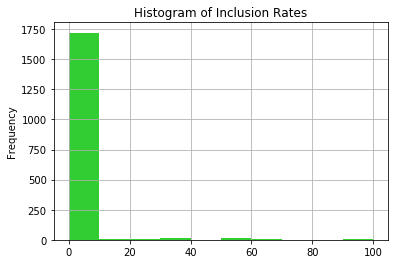

-- Mean inclusion rate 1.23319209039548
-- Median inclusion rate 0.0
--------------------------

For each predicted text, how much of it is extra content not in the test paragraph?


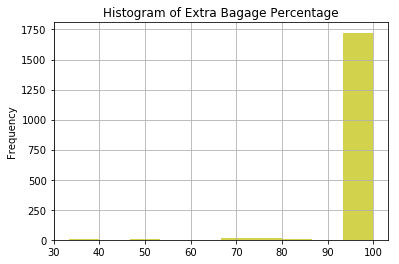

-- mean bagage rate:  98.98972347629794
-- median bagage rate:  100.0
----------------

What is the distribution of lengths of the word tokenized test texts.


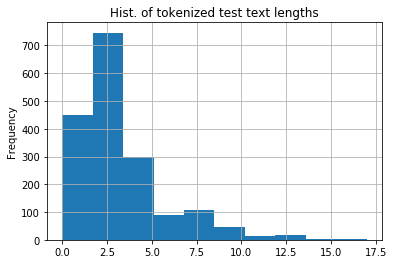

-- Mean tokenized test length  3.3188487584650113
-- Median tokenized test length 3.0
-- Range of tokenized test lengths 17.0
------------------------------

What is the distribution of lengths of the word tokenized test texts.


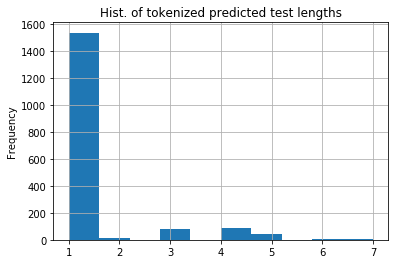

-- mean tokenized predicted text lenghts 1.3718961625282167
-- median tokenized predicted text lenghts 1.0
-- range of tokenized predicted text lenghts 6.0
------------------------------



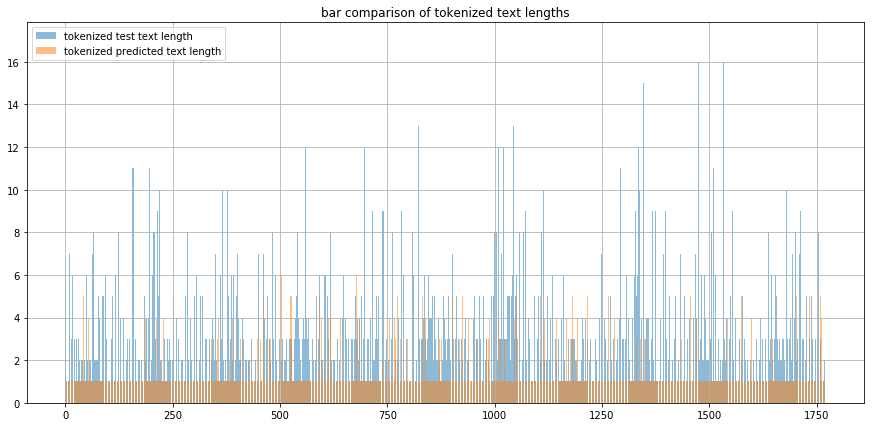

In [114]:
# report and plot the overall inclusion
print('='*30, 'Inclusion Report', '='*50)

# total inclusion rate
print("For each test text, how many of them are 100% included in the predicted text?")
print(round(100*(share_rprchs_prgrph_df.predtext_totinc.sum())/len(share_rprchs_prgrph_df.predtext_totinc), 2), '% total inclusion')
print("-"*30)

# report inclusion_rate
print('For each test text, how much of it is included in the corresponding predicted text?')
share_rprchs_prgrph_df.predtext_inclpct.plot(kind = 'hist', color = 'limegreen', alpha = 1)
plt.title('Histogram of Inclusion Rates')
plt.grid()
plt.show()
print('-- Mean inclusion rate', np.mean(share_rprchs_prgrph_df.predtext_inclpct))
print('-- Median inclusion rate', share_rprchs_prgrph_df.predtext_inclpct.median())
print("--------------------------")
print("")

# report extra baggage rate
print('For each predicted text, how much of it is extra content not in the test paragraph?')
share_rprchs_prgrph_df.predtext_bggpct.plot(kind = 'hist', color = 'y', alpha = .7)
plt.title('Histogram of Extra Bagage Percentage')
plt.grid()
plt.show()
print('-- mean bagage rate: ', np.mean(share_rprchs_prgrph_df.predtext_bggpct))
print('-- median bagage rate: ', share_rprchs_prgrph_df.predtext_bggpct.median())
print("----------------")
print("")

# report lengths of tokenized test strings
print("What is the distribution of lengths of the word tokenized test texts.")
share_rprchs_prgrph_df.testtext_tknzdlen.plot(kind = 'hist')
plt.title('Hist. of tokenized test text lengths')
plt.grid()
plt.show()
print('-- Mean tokenized test length ', np.mean(share_rprchs_prgrph_df.testtext_tknzdlen))
print('-- Median tokenized test length', share_rprchs_prgrph_df.testtext_tknzdlen.median())
print('-- Range of tokenized test lengths', np.max(share_rprchs_prgrph_df.testtext_tknzdlen) - np.min(share_rprchs_prgrph_df.testtext_tknzdlen))
print("-"*30)
print("")

# report lengths of tokenized predicted strings
print("What is the distribution of lengths of the word tokenized test texts.")
share_rprchs_prgrph_df.predtext_tknzdlen.plot(kind = 'hist')
plt.title('Hist. of tokenized predicted test lengths')
plt.grid()
plt.show()
print('-- mean tokenized predicted text lenghts', np.mean(share_rprchs_prgrph_df.predtext_tknzdlen))
print('-- median tokenized predicted text lenghts', share_rprchs_prgrph_df.predtext_tknzdlen.median())
print('-- range of tokenized predicted text lenghts', (np.max(share_rprchs_prgrph_df.predtext_tknzdlen)) - np.min(share_rprchs_prgrph_df.predtext_tknzdlen))
print("-"*30)
print("")
# plot overlay of each string's lengths
plt.figure(figsize = (15,7))
plt.bar(height = share_rprchs_prgrph_df.testtext_tknzdlen.fillna(np.nan), alpha = 0.5,
        x = range(len(share_rprchs_prgrph_df.text)))
plt.bar(height = share_rprchs_prgrph_df.predtext_tknzdlen.fillna(np.nan), alpha = 0.5,
        x = range(len(share_rprchs_prgrph_df.text)))
plt.title('bar comparison of tokenized text lengths')
plt.legend(['tokenized test text length', 'tokenized predicted text length'])
plt.grid()
plt.show()

In [115]:
list(set(share_rprchs_prgrph_df.data_key_friendly_name))

['Share Repurchase Intention',
 'Share Repurchase Utilization',
 'Amount Spent on Share Repurchases',
 'Share Repurchase Count',
 'Share Repurchase Authorization Date',
 'Unknown Share Repurchase Data',
 'Share Repurchase Authorization']

## examine output

In [116]:
share_rprchs_prgrph_df.head(3)

,ticker,accession_number,data_key_friendly_name,text,data_value,reported_data_value,reported_units,paragraph_text,pred_par,amount,...,baggage_pct,tknzd_pred_par_len,pred_text,predtext_proba,predtext_totinc,predtext_inclpct,predtext_bggpct,testtext_totinc,predtext_tknzdlen,testtext_tknzdlen
0,A,0001090872-17-000018,Share Repurchase Authorization Date,"May 28, 2015",20150528,20200000.00,ones,"On May 28, 2015 we announced that our board ...","ases under this authorization. on may 28, 2015...",0,...,40.00,110,,0,False,0.0,100.0,NaN,1.0,3.0
1,A,0001090872-17-000018,Share Repurchase Authorization,The 2015 share repurchase program authorizes t...,1140000000,1.14,billions,"On May 28, 2015 we announced that our board ...","31, 2016 we repurchased approximately 2.4 mil...",0,...,40.91,110,,0,False,0.0,100.0,NaN,1.0,6.0
2,A,0001090872-17-000018,Share Repurchase Intention,remaining authorization to repurchase up to,610000000,610.00,millions,"Table of Contents 2016, upon the completion ...","zation. on may 28, 2015 we announced that our ...",0,...,47.27,110,,0,False,0.0,100.0,NaN,1.0,3.0


In [117]:
for i in range(len(share_rprchs_prgrph_df[0:20])):
    print('='*30, 'Compare test to predicted text', '='*30)
    print("DKFN:", share_rprchs_prgrph_df.data_key_friendly_name[i])
    print('-- Test Text:', share_rprchs_prgrph_df.text[i])
    print('  ', ". "*30)
    print('-- Pred Text:', share_rprchs_prgrph_df.pred_text[i])
    print('-'*60)

============================== Compare test to predicted text ==============================
DKFN: Share Repurchase Authorization Date
-- Test Text: May 28, 2015
   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
-- Pred Text: 
------------------------------------------------------------
============================== Compare test to predicted text ==============================
DKFN: Share Repurchase Authorization
-- Test Text: The 2015 share repurchase program authorizes the purchase of up to
   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
-- Pred Text: 
------------------------------------------------------------
============================== Compare test to predicted text ==============================
DKFN: Share Repurchase Intention
-- Test Text: remaining authorization to repurchase up to
   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
-- Pred Text: 
------------------------------------------------------------
=======================

Share Repurchase Intention
For each test text, how many of them are 100% included in the predicted text?
0.0 % total inclusion
------------------------------
For each test text, how much of it is included in the corresponding predicted text?


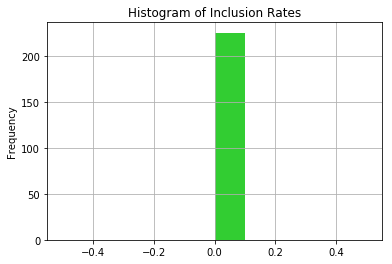

-- Mean inclusion rate 0.0
-- Median inclusion rate 0.0
--------------------------

Share Repurchase Utilization
For each test text, how many of them are 100% included in the predicted text?
0.0 % total inclusion
------------------------------
For each test text, how much of it is included in the corresponding predicted text?


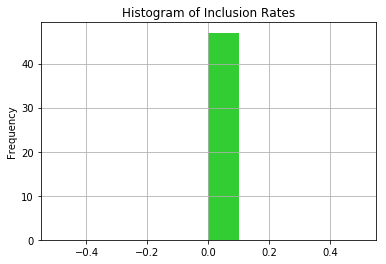

-- Mean inclusion rate 0.0
-- Median inclusion rate 0.0
--------------------------

Amount Spent on Share Repurchases
For each test text, how many of them are 100% included in the predicted text?
0.3 % total inclusion
------------------------------
For each test text, how much of it is included in the corresponding predicted text?


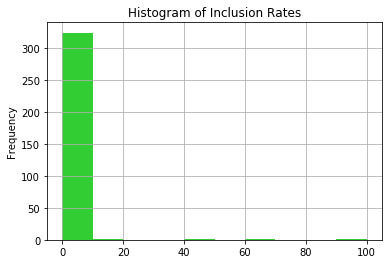

-- Mean inclusion rate 0.6809146341463416
-- Median inclusion rate 0.0
--------------------------

Share Repurchase Count
For each test text, how many of them are 100% included in the predicted text?
0.0 % total inclusion
------------------------------
For each test text, how much of it is included in the corresponding predicted text?


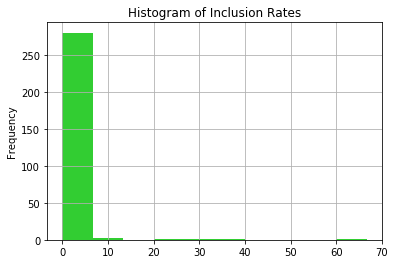

-- Mean inclusion rate 0.6643356643356644
-- Median inclusion rate 0.0
--------------------------

Share Repurchase Authorization Date
For each test text, how many of them are 100% included in the predicted text?
1.0 % total inclusion
------------------------------
For each test text, how much of it is included in the corresponding predicted text?


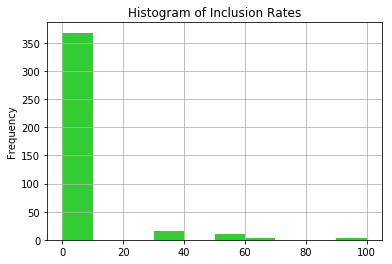

-- Mean inclusion rate 4.03149625935162
-- Median inclusion rate 0.0
--------------------------

Unknown Share Repurchase Data
For each test text, how many of them are 100% included in the predicted text?
0.0 % total inclusion
------------------------------
For each test text, how much of it is included in the corresponding predicted text?


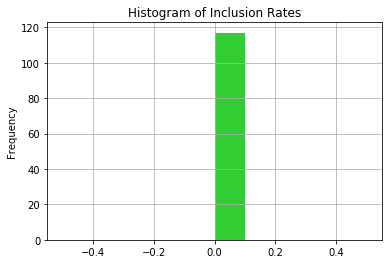

-- Mean inclusion rate 0.0
-- Median inclusion rate 0.0
--------------------------

Share Repurchase Authorization
For each test text, how many of them are 100% included in the predicted text?
0.0 % total inclusion
------------------------------
For each test text, how much of it is included in the corresponding predicted text?


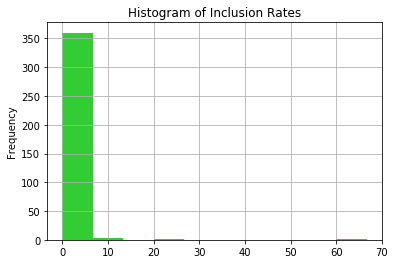

-- Mean inclusion rate 0.41743169398907104
-- Median inclusion rate 0.0
--------------------------



In [118]:
# look at the inclusion rates by dkfn
for dkfn in list(set(share_rprchs_prgrph_df.data_key_friendly_name)):
    print("=======================================")
    print(dkfn)
    print("=======================================")
    report_inclusion(share_rprchs_prgrph_df[share_rprchs_prgrph_df.data_key_friendly_name == dkfn])

## write out the csv

In [119]:
#share_rprchs_prgrph_df.to_csv('inv_tfidf_marg12.csv')
#share_rprchs_prgrph_df.to_csv('count_vect_marg12_tfidf_vctrzr_paragraphs.csv')
share_rprchs_prgrph_df.to_csv('count_vect_marg12_paragraphs.csv')

In [120]:
assert True == False

AssertionError: 

## test components above

In [ ]:
get_tfidf_ML_paragraph(nominees, string_filing, verbose = False, inverse= True)

## test tfidf vectorizer predictions

In [ ]:
for filing in training_filings_list[0:10]:
    '''# read in an html
    with open(filing) as file:
          file_html = file.read()
    # parse html
    parsed_html = BeautifulSoup(file_html)
    # filter out the html head, css, and cast to lower case
    string_filing = parsed_html.body.text.lower()'''
    
    
    nom_pars, string_filing = define_nominated_paragraphs(filing, dkfn_kts_dict['auth_kts'], margin)
    #nom_pars[0:5]
    
    
    
    nominee = ''
    best_proba = 0.0
    for tpl in nom_pars:
        # generate par
        par = string_filing[tpl[0]:tpl[1]]
        # pre process par
        par = re.sub(r'\n+', ' ', par)
        par = re.sub(r'\s+', ' ', par)
        # tfidf_vectorize the string into a sparse matrix
        par_tfidf_vectorized = tfidf_vectorizer.transform([par])
        # if the naiver bayes prediction of classification as a given dkfn's class is new_best probability
        if nb_auth_classifier.predict(par_tfidf_vectorized)[0] == 1 and nb_auth_classifier.predict_proba(par_tfidf_vectorized)[0][1] > best_proba:
            #print(nb_auth_classifier.predict_proba(par_tfidf_vectorized))
            nominee = par
            #print(nominee)
            best_proba = nb_auth_classifier.predict_proba(par_tfidf_vectorized)[0][1]
    
    print('best probability', best_proba)
    print('-'*100)
    print(nominee)
    print('='*100)

My Results are rather bad, based on visual inspection. 
- I have a feeling this is because the tfidf vectorizer is penalizing paragraphs that have precisely those terms that are most common in the training data. 
    - Well, all I know is that tfidf assigns low scores to terms that are super frequent across documents
        - i.e. 'authorized'
    - And it assigns high scores to terms that are frequent across documents
    - the result is that if 'authorized' appeard only once in each paragraph cell it would be scored very high
        - but the more it appears in each cell the more it gets penalized
- Then naive bayes is doing something (i know not what) to the effect of:
    - given that your paragraph has 'authorized' in it, how likely is it to be an authorization dkfn, as opposed to not. 
        - since all of or most of them have 'authorized' in there it probably thinks this term is rather irrelevant. 
        
 The problem is that my models are optimized to distinguish between relevant paragraphs, and to classify them based on their minor differences.
 - so it rewards paragraphs that have terms that are very rare in the training paragraphs
 - it's optimized to "split" hairs between good paragraphs, so it's trying to get as far away as possible from the "average" good paragraph, while still having "a toe" in the domain of their key tokens. 
 
If the model had been fit on noise and signal, it would be good at identifying noise. But since it was fit on signals 1 - 7, it is biased towards picking noise that is as unsimilar as possible to signals 1-7.

I, think... 🤔 

If my hypothesis is correct, then a count vectroizer should reward paragraphs that are most similar to training paragraphs
        

# Let's try out the results with a count vectorizer

In [ ]:
count_vectorizer = CountVectorizer(stop_words='english')
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)
second_nb_classifier = MultinomialNB()


In [ ]:
## Try out count vectorizer on 'authorization'
y_train = share_rprchs_prgrph_df.authorization[[ix in y_train_ix for ix in share_rprchs_prgrph_df.index]]

In [ ]:
y_test = share_rprchs_prgrph_df.authorization[[ix in y_test_ix for ix in share_rprchs_prgrph_df.index]]

In [ ]:
second_nb_classifier.fit(count_train, y_train)

In [ ]:
count_predictions = second_nb_classifier.predict(count_test)
metrics.accuracy_score(y_test, count_predictions)

In [ ]:
for filing in training_filings_list[0:10]:
    # read in an html
    with open(filing) as file:
          file_html = file.read()
    # parse html
    parsed_html = BeautifulSoup(file_html)
    # filter out the html head, css, and cast to lower case
    string_filing = parsed_html.body.text.lower()
    
    
    
    nom_pars = define_nominated_paragraphs(filing, dkfn_kts_dict['auth_kts'], margin)
    #nom_pars[0:5]
    
    
    
    nominee = ''
    best_proba = 0.0
    for tpl in nom_pars:
        # generate par
        par = string_filing[tpl[0]:tpl[1]]
        # pre process par
        par = re.sub(r'\n+', ' ', par)
        par = re.sub(r'\s+', ' ', par)
        
        # tfidf_vectorize the string into a sparse matrix
        #par_tfidf_vectorized = tfidf_vectorizer.transform([par])
        
        # count_vectorize the string into a sparse matrix
        vectorized_par = count_vectorizer.transform([par])
        
        # if the naiver bayes prediction of classification as a given dkfn's class is new_best probability
        if second_nb_classifier.predict(vectorized_par)[0] == 1 and second_nb_classifier.predict_proba(vectorized_par)[0][1] > best_proba:
            #print(nb_auth_classifier.predict_proba(par_tfidf_vectorized))
            nominee = par
            #print(nominee)
            best_proba = second_nb_classifier.predict_proba(vectorized_par)[0][1]
    
    print('best probability', best_proba)
    print('-'*100)
    print(nominee)
    print('='*100)

Again, the problem is that the model is optimized to reward the hairsplit differences between 7 signals. 
- so since 'authorization' appears in most of the 7 signals, it's relevance is ignored or downplayed
- whereas if 'further' appears more often in authorization signal than in the others, then it's going to pick noise paragraphs that have a hig count of the term 'further'

# 😜 if my models are so good at being bad, then what if I use the opposite of their prediction?

Ok, well let's try it for the count vectorizer. 
- although, I guess the key toks would get us in the "weather system"
- but the inverse count vecotrized prediction would reward the terms that were frequent across all of a dkfn's 'authorization' training paragraphs...

This did not work well for the inverse count prediction. I got 0/10 hits on 'authorized'

Try it again with the prediction being true, but then select the one with the lowes probability of being true. 
- no hits on 'authorized'
- 1/10 for 'repurchased'

😂 that worked for 5/10 with the tfidf on 'authorized'
- got 11/20 for 'authorized' with the inverse tfidf = 55%
- got 25/40 for 'authorized' with the inverse tfidf = 62.5%

So what is going on?
- if we think of each dkfn's paragraph cluster as a 'weather system' then the densest clouds represent the overlap, the commonalities between all that dkfn's paragraphs. all of that signals commonalities
- the tk_hits defines the 'weather system' 
- the tfidf rewards the 'edgiest' of the points, the outlier signals.
- the inverse tfidf rewards not what the dkfn paragraphs have in common, but rather what they have in common with the other signals. 
    - so it does a good job of getting us into the overlap between the signlas, it sort of defines the generica 'mean' signal. But it is not equipped to distinguish between noise and a given signal. 
    - it is only equipped to discern between the 7 signals. 
    
analogy:
- if i trained three models for classifying three instruments
    - rough electric guitar
        - the guitar model would determine that what stood out most about the electric guitar was it's low end growl and distortion
    - flute
       - the flute model would reward the sound of blowing
    - and drums
        - the drum model would reward percussion
- all three models would consider, rythm, and melody irrelevant (because all three instruments have those features).
- when 'released into the wild' 
    - the guitar model would prefer a diesel engine to an actual electric guitar
    - the flute model would prefer a tornado instead of any wind instrument
    - the drum model would prefer a jackhammer or construction zone over any percussion instrument
- the models would go out of their way to pass over instruments.


In [ ]:
for filing in training_filings_list[0:40]:
    # read in an html
    with open(filing) as file:
          file_html = file.read()
    # parse html
    parsed_html = BeautifulSoup(file_html)
    # filter out the html head, css, and cast to lower case
    string_filing = parsed_html.body.text.lower()
    
    
    
    nom_pars = define_nominated_paragraphs(filing, dkfn_kts_dict['auth_kts'], margin)
    #nom_pars[0:5]
    
    
    
    nominee = ''
    best_proba = 0.0
    for tpl in nom_pars:
        # generate par
        par = string_filing[tpl[0]:tpl[1]]
        # pre process par
        par = re.sub(r'\n+', ' ', par)
        par = re.sub(r'\s+', ' ', par)
        # tfidf_vectorize the string into a sparse matrix
        par_tfidf_vectorized = tfidf_vectorizer.transform([par])
        # if the naiver bayes prediction of classification as a given dkfn's class is new_best probability
        if nb_auth_classifier.predict(par_tfidf_vectorized)[0] == 0 and nb_auth_classifier.predict_proba(par_tfidf_vectorized)[0][0] > best_proba:
            #print(nb_auth_classifier.predict_proba(par_tfidf_vectorized))
            nominee = par
            #print(nominee)
            best_proba = nb_auth_classifier.predict_proba(par_tfidf_vectorized)[0][0]
    
    print('best probability', best_proba)
    print('-'*100)
    print(nominee)
    print('='*100)